## Partie 3 : modélisation 

In [2]:
import statsmodels.api as sm
import pandas as pd
import re 
from tqdm import tqdm
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
parisiens=pd.read_csv("C:/Users/GUILLOT Robin/Documents/Robin Ensae/Matières/Python/tablefinalisee.csv", sep = ';')

In [4]:
parisiens

,legalImmat,streetNumber,streetName,Code Postal,city,isHeadquarters,legalName,legalStructure,employeesNb,categorySize,...,Note Globale,Catégorie de prix,Note de cuisine,Note de service,Note qualité-prix,Note ambiance,Nombre avis,Prix inf,Prix sup,Prix moyen
0,304305519,5.0,AVENUE DU MAINE,75015,PARIS 15,1,LES CEDRES DU LIBAN,SARL,6.0,PME,...,4.5,moyen,4.5,4.5,4.0,3.5,850.0,8.0,21.0,14.5
1,306332362,25.0,RUE DE LA HUCHETTE,75005,PARIS 5,1,LE SOUVLAKI ATHENIEN,SARL,0.0,PME,...,4.0,faible,4.0,4.0,4.0,4.0,59.0,4.0,15.0,9.5
2,307711895,15.0,PLACE DU TERTRE,75018,PARIS 18,1,LA CREMAILLERE DE MONTMARTRE,SAS,20.0,PME,...,3.5,moyen,3.5,3.5,3.5,4.0,1036.0,17.0,37.0,27.0
3,318906591,11.0,RUE DE L ARRIVEE,75015,PARIS 15,0,LA BRIOCHE DOREE,SAS,1900.0,ETI,...,4.0,faible,4.0,3.5,4.0,3.5,421.0,NaN,NaN,NaN
4,319947537,14.0,RUE MABILLON,75006,PARIS 6,1,BRASSERIE DE LA GRILLE SAINT-GERMAIN,SAS,18.0,PME,...,3.0,moyen,3.0,3.5,3.0,3.5,336.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13274,822730586,16.0,RUE DE LA GRANDE CHAUMIERE,75006,PARIS 6,0,SAS DU 8 MARS,SAS,NaN,NaN,...,4.5,moyen,4.5,4.5,4.5,4.5,441.0,21.0,35.0,28.0
13275,823268370,17.0,RUE VIGNON,75008,PARIS 8,1,HU JIN,SARL,NaN,NaN,...,4.0,élevé,4.5,4.5,3.5,3.5,167.0,NaN,NaN,NaN
13276,823628706,115.0,BOULEVARD DAVOUT,75020,PARIS 20,1,YASMINE D'ORIENT,SARL,NaN,NaN,...,4.0,faible,4.0,4.0,4.0,4.0,288.0,NaN,NaN,NaN
13277,823812573,248.0,RUE DU FBG ST ANTOINE,75012,PARIS 12,1,CHEZ XIA,SAS,NaN,NaN,...,2.5,faible,3.0,3.0,3.0,NaN,27.0,NaN,NaN,NaN


 ### Création d'un modèle de régression linéaire

Nous avons deux variables pour le prix : 

- catégorie de prix, toujours renseigée mais peu précise
- prix moyen ( prix min, prix max), moins souvent renseignée mais plus précise

In [285]:
nb_valeurs_manquantes_categorie_prix=len(parisiens)-parisiens["Catégorie de prix"].count()
nb_valeurs_manquantes_prix_moyen=len(parisiens)-parisiens["Prix moyen"].count()

print("Nombre de valeurs manquantes pour catégorie de prix : ",nb_valeurs_manquantes_categorie_prix)
print("\nNombre de valeurs manquantes pour prix moyen :",nb_valeurs_manquantes_prix_moyen)

Nombre de valeurs manquantes pour catégorie de prix :  1305

Nombre de valeurs manquantes pour prix moyen : 7550


On va dans la suite se concentrer sur la variable de prix moyen

Avant de créer notre modèle de régression, on se rend compte qu’on a beaucoup de variables explicatives pour le Prix. Ainsi on est en droit de se poser les questions suivantes : doit-on choisir toutes ces variables pour le modèle ? Quelles sont les variables qui peuvent avoir une plus forte relation linéaire avec le PRIX ?

Rappelons les variables explicatives potentielles : 

In [286]:
parisiens.columns

Index(['legalImmat', 'streetNumber', 'streetName', 'Code Postal', 'city',
       'isHeadquarters', 'legalName', 'legalStructure', 'employeesNb',
       'categorySize', 'foundingYear', 'sourceLastUpdate', 'name', 'dep',
       'Code INSEE', 'Département', 'Région', 'Altitude Moyenne', 'Superficie',
       'PTOT', 'Niveau de vie Commune', 'Niveau de vie Département', 'HT20',
       'HT120', 'HT220', 'HT320', 'HT420', 'HT520', 'CPG20', 'RT20', 'arr',
       'nb_emeraudes', 'Capital Social', 'Lien TripAdvisor',
       'Style de nourriture', 'Note Globale', 'Catégorie de prix',
       'Note de cuisine', 'Note de service', 'Note qualité-prix',
       'Note ambiance', 'Nombre avis', 'Prix inf', 'Prix sup', 'Prix moyen'],
      dtype='object')

Variables externes, pas spécifique au resto, pour capturer l'effet de l'arrondissement où se situe le restaurant, via :  

- niveau de vie commune : niveau de vie par habitant de l'arrondissement
- superficie : taille de l'arrondissement
- PTOT : population dans l'arrondissement
- HT20 : nombre d'hôtels en 2020 dans l'arrondissement
- HT120 : nombre d'hôtels 1 étoile en 2020 dans l'arrondissement
- HT220 : nombre d'hôtels 2 étoiles en 2020 dans l'arrondissement
- HT320 : nombre d'hôtels 3 étoiles en 2020 dans l'arrondissement
- HT420 : nombre d'hôtels 4 étoiles en 2020 dans l'arrondissement
- HT520 : nombre d'hôtels 5 étoiles en 2020 dans l'arrondissement
- CPG20 : nombre de camping en 2020 ( pas pertinente ici : on travaille seulement sur Paris !)
- RT20 : nombre de résidences de tourisme et hébergements assimilés en 2020 dans l'arrondissement
- nb_émeraudes : nombre de restaurants émeraudes dans l'arrondissement


Variables capturant des critères spécifiques au restaurant : 

- categorySize : taille du restaurant (petite entreprise (PE) / grande entreprise (GE))
- employeesNb : nombre d'employés
- capital social : capital social du restaurant
- note globale
- note de cuisine
- note de service
- note qualité-prix
- note ambiance
- nombre d'avis

On va créer une matrice de corrélation pour étudier les relations entre les variables explicatives et leur relation avec la variable à expliquer (prix moyen)

D'abord, on vérifie que toutes nos variables ont des valeurs numériques : 

In [287]:
print(parisiens["Prix moyen"].dtype)
print(parisiens["Niveau de vie Commune"].dtype)
print(parisiens["Superficie"].dtype)
print(parisiens["PTOT"].dtype)
print(parisiens["HT20"].dtype)
print(parisiens["HT120"].dtype)
print(parisiens["HT220"].dtype)
print(parisiens["HT320"].dtype)
print(parisiens["HT420"].dtype)
print(parisiens["HT520"].dtype)
print(parisiens["RT20"].dtype)
print(parisiens["nb_emeraudes"].dtype)
print(parisiens["categorySize"].dtype)
print(parisiens["employeesNb"].dtype)
print(parisiens["Capital Social"].dtype)
print(parisiens["Note Globale"].dtype)
print(parisiens["Note de cuisine"].dtype)
print(parisiens["Note de service"].dtype)
print(parisiens["Note qualité-prix"].dtype)
print(parisiens["Note ambiance"].dtype)
print(parisiens["Nombre avis"].dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64


Il y a juste la variable categorySize à recoder : 

In [6]:
# On recode en 1/2/3 : 

def transfo(s):
    if s=='PME':                 # petite/moyennes entreprises
        return 1
    elif s=='ETI':              # entreprises de taille intermédiaire
        return 2
    elif s=='GE':               # grandes entreprises
        return 3
    return s

parisiens["categorySize"]=parisiens["categorySize"].apply(lambda s: transfo(s))

#### Matrice de corrélation

In [7]:
df=parisiens[["Prix moyen","Niveau de vie Commune","Superficie","PTOT","HT20","HT120","HT220",
              "HT320","HT420","HT520","RT20","nb_emeraudes","categorySize","employeesNb","Capital Social",
              "Note Globale","Note de cuisine","Note de service","Note qualité-prix","Note ambiance","Nombre avis"]]

In [289]:
df["Prix moyen"].describe()

count    5.729000e+03
mean     9.085394e+02
std      6.605869e+04
min      1.500000e+00
25%      1.500000e+01
50%      2.200000e+01
75%      3.500000e+01
max      5.000000e+06
Name: Prix moyen, dtype: float64

On l'a vue dans la partie précédente, on a trois valeurs aberrantes pour les prix, qu'on enlève donc avant de calculer notre matrice de corrélation

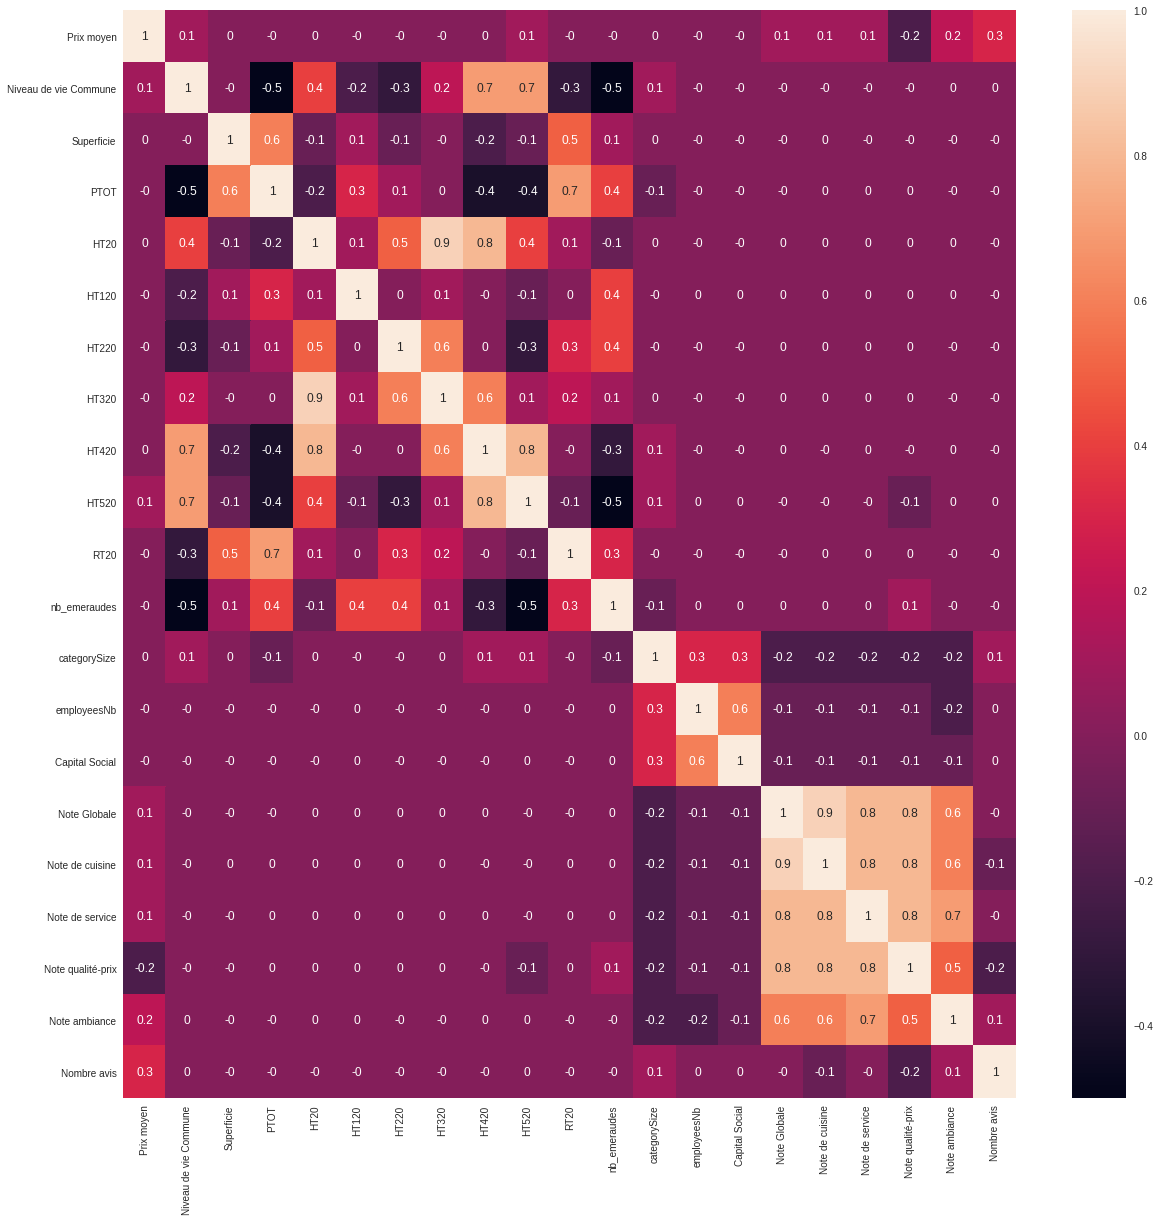

In [290]:
dg = df[df['Prix moyen'] < 2000]

matrice_corr=dg.corr().round(1)

plt.figure(figsize=(20, 20))
sns.heatmap(matrice_corr,annot=True)

Observations : 

##### 1) Concernant les liens entre nos variables explicatives : 
* le niveau de vie de l'arrondissement est assez corrélé (et positivement) au nombre d'hôtels 4 étoiles et 5 étoiles dans cet arrondissement ( corrélation de 0.7). 
* la superficie et la population totale de l'arrondissement(PTOT) ont une corrélation également non négligeable, de 0.6, ce qui apparaît naturel : les plus grands arrondissements sont les plus peuplés.
* la population de l'arrondissement est également assez corrélée avec la variable RT20, le nombre de résidences de tourisme en 2020 (corrélation de 0.7)
* Concernant nos variables de tourisme (HT20, HT120...,HT520), HT20 est très corréléee avec HT320 et HT420 (corrélations de 0.8 et 0.9), tandis que HT420 et HT520 sont également assez corrélées(0.8), ce qui n'est pas surprenant, les hôtels très luxueux étant souvent regroupées dans des mêmes zones
* employeesNb et capital social ont une corrélation positive de 0.6, pas étonnant non plus : les plus grands restaurants sont ceux qui disposent de plus de moyens, y compris de plus gros capital social et de de trésorerie pour payer un nombre important d'employés
* Concernant nos variables de note (note globale, de cuisine,d'ambiance...), note globale et note de cuisine sont très corrélées (0.9). En effet, sur TripAdvisor, il n'est pas rare que les deux soient confondues : beaucoup de personnes notent en effet un restaurant seulement sur ce critère. De plus, note globale, note de service et note qualité-prix sont également assez corrélées (0.8).

##### 2) Concernant le liens de nos variables explicatives avec le prix moyen: 

Ici, beaucoup de variables présentent une faible corrélation linéaire avec le prix : on a nombre d'avis, note d'ambiance et note qualité prix qui ont la plus forte corrélation avec celle-ci, mais cela reste faible (0.3, pas plus)

On peut juste voir ce qu'on obtient en traçant notre matrice de corrélation avec cette fois-ci les coefficients calculés par la méthode des "rangs de Spearman", qui sont plus robustes aux valeurs extrêmes et évaluent non pas des relations linéaires mais monotones entre variables. 

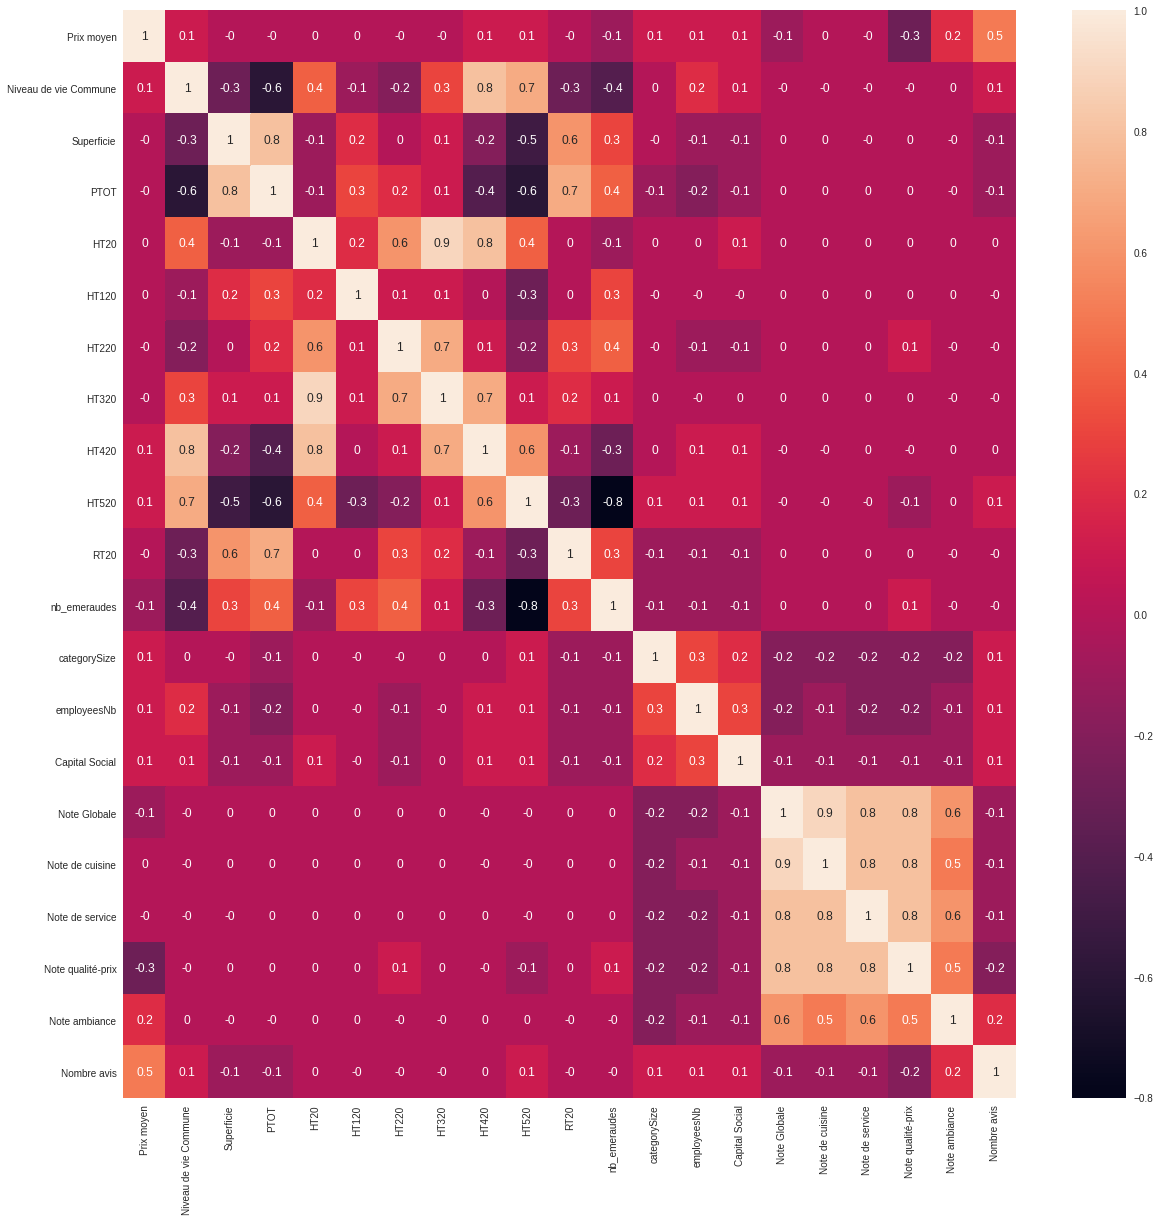

In [291]:
matrice_corr_spear=dg.corr('spearman').round(1)

plt.figure(figsize=(20, 20))
sns.heatmap(matrice_corr_spear,annot=True)

Les conclusions entre variables explicatives sont identiques. Par contre, on voit que la corrélation entre nombre d'avis et prix moyen est plus marquée (0.5) ainsi qu'entre note de qualité-prix et prix moyen (-0.3)

 Il faut savoir que lorsqu’on fait une régression linéaire on pose certaines hypothèses notamment la Non-colinéarité des variables explicatives (une variable explicative ne doit pas pouvoir s’écrire comme combinaison linéaire des autres). Ainsi, et au vu de tout ce qui a été dit sur les corrélations, on retient pour notre modèle de régression linéaire les variables :
 
- PTOT
- HT 20    
- HT 520
- nb_emeraudes
- capital Social
- Note qualité-prix
- Note ambiance
- Nombre avis

#### Régression linéaire avec statsmodels

In [10]:
dh=dg[["Prix moyen","PTOT","HT20","HT520","nb_emeraudes","Capital Social","Note qualité-prix","Note ambiance","Nombre avis"]]

 On effectue la régression linéaire multiple de Prix moyen sur toutes les autres colonnes de dh

In [ ]:
X = dh.drop(['Prix moyen'], axis = 1)
X = sm.add_constant(X) 
y = dh["Prix moyen"]

model = sm.OLS(y, X,missing='drop')
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Prix moyen   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     63.77
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.64e-96
Time:                        20:20:18   Log-Likelihood:                -14173.
No. Observations:                2900   AIC:                         2.836e+04
Df Residuals:                    2891   BIC:                         2.842e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.6440      6.05

On remarque que la qualité de la régression est  très médiocre : le R² associé est faible, égal à 0.150. En outre, le programme nous informe que du fait de la valeur élevée du nombre de conditions, il doit exister encore des problèmes de multicolinéarité.

Si l'on s'intéresse aux erreurs standards de chaque coefficient, et aux p-valeurs des tests associés, on voit que :

- les notes qualité/prix, note d'ambiance et nombre d'avis ont une p-valeur nulle (donc sont statistiquement significatives, au seuil de 1% par exemple).
C'est d'ailleurs avec ces 3 variables que la corrélation avec le Prix moyen était la plus grande

- pour la variable PTOT, la p-valeur associée est 0.014 : elle est donc statistiquement significative au seuil de 5%.

- pour la variable HT520, la p-valeur associée est 0.098 : elle est donc statistiquement significative au seuil de 10%.

Pour toutes les autres variables, la p-valeur est grande, elles ne sont pas significatives...

On peut aussi réaliser quelques régressions linéaires simples du prix_moyen sur nos variables précédentes pour voir si la qualité des régressions augmente : 

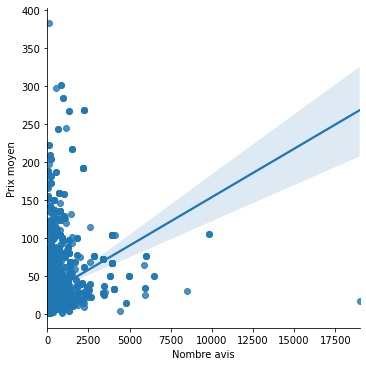

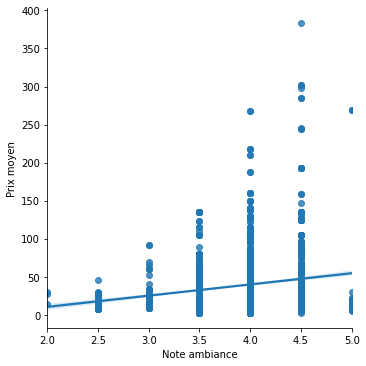

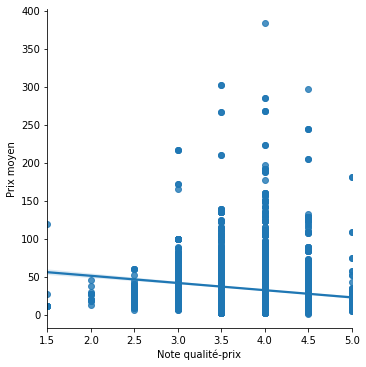

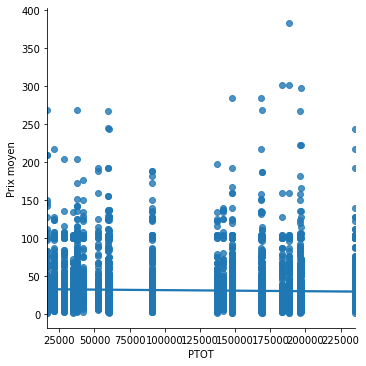

In [ ]:
# régression simple de prix_moyen sur Nombre avis, Note ambiance, Note qualité-prix, PTOT

sns.lmplot(x="Nombre avis", y="Prix moyen", data=dh)
sns.lmplot(x="Note ambiance", y="Prix moyen", data=dh)
sns.lmplot(x="Note qualité-prix", y="Prix moyen", data=dh)
sns.lmplot(x="PTOT", y="Prix moyen", data=dh)


Pour PTOT : aucune relation linéaire !

Examinons pour les autres en effectuant la régression avec statsmodels : 

In [ ]:
X1 = dh["Nombre avis"]
X1 = sm.add_constant(X1) 
X2 = dh["Note qualité-prix"]
X2 = sm.add_constant(X2)
X3 = dh["Note ambiance"]
X3 = sm.add_constant(X3)

y = dh["Prix moyen"]

model1 = sm.OLS(y, X1,missing='drop')
results1 = model1.fit()
print("Régression de Prix_moyen sur Nombre avis",results1.summary())

model2 = sm.OLS(y, X2,missing='drop')
results2 = model2.fit()
print("Régression de Prix_moyen sur Note qualité-prix",results2.summary())

model3 = sm.OLS(y, X3,missing='drop')
results3 = model3.fit()
print("Régression de Prix_moyen sur Note ambiance",results3.summary())



Régression de Prix_moyen sur Nombre avis                             OLS Regression Results                            
Dep. Variable:             Prix moyen   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     560.9
Date:                Mon, 14 Dec 2020   Prob (F-statistic):          2.27e-118
Time:                        01:04:13   Log-Likelihood:                -27438.
No. Observations:                5725   AIC:                         5.488e+04
Df Residuals:                    5723   BIC:                         5.489e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const    

Les résultats obtenus ici sont très peu concluants, en outre la qualité de nos régressions est très faible. 
On peut évoquer 4 grandes limites :  

1)problème de multi-colinéarité

2) problème de données non standardisées : la régression linéaire suppose des données empiriques un minimum standardisées (c'est-à-dire la distribution empirique suit une loi normale)

3)problème des non-réponses, très importantes pour la variable prix_moyen

4)envisager d'autres types de relation. Ex : régression polynomiale

Dans la suite, nous allons entre-autre pousser l'analyse exploratoire des données à travers une ACP, qui nous conduira ensuite à faire du clustering.

Puis nous réaliserons quelques régressions linéaires à l'aide de Scikit-learn.


### ACP

In [11]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


In [292]:
# Avant toutes choses, on enlèves les valeurs manquantes du DataFrame 

dk=dg.dropna(how="any")
dk.shape

(2352, 21)

Cela a réduit considérablement le volume de nos données, passant de plus de 13000 à 2352 !

On commence par une standardisation : 

In [293]:
sc = StandardScaler()
Z = sc.fit_transform(dk)
print(Z)

[[-0.67435354  0.08812737  0.88488167 ...  0.50786012 -0.87131313
   0.27824239]
 [-0.81592607  0.43389773 -0.61751128 ...  0.50786012  0.22049746
  -0.5833835 ]
 [-0.32042221 -1.52591285  0.27279565 ... -0.47850405  0.22049746
   0.48084974]
 ...
 [ 0.68474275  0.40649787 -0.70350684 ... -0.47850405 -0.87131313
   0.82833225]
 [-0.77345431  0.08812737  0.88488167 ...  2.48058847  2.40411864
  -0.60734781]
 [-0.46199474  0.40649787 -0.70350684 ...  0.50786012  0.22049746
  -0.4918834 ]]


Illustration de l'effet obtenu sur quelques variables :

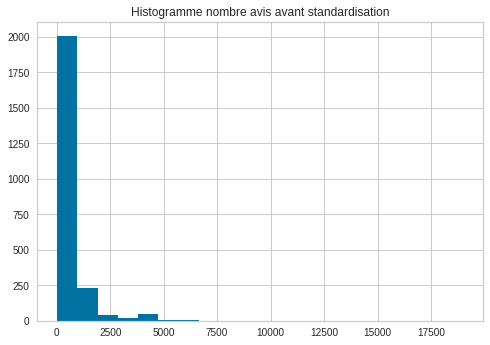

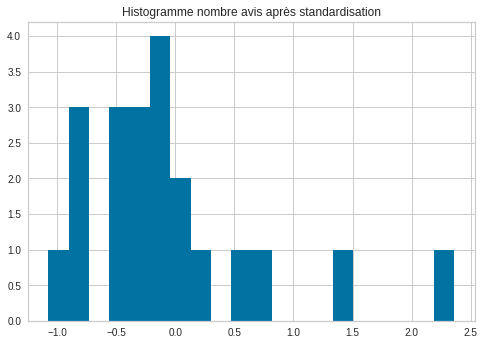

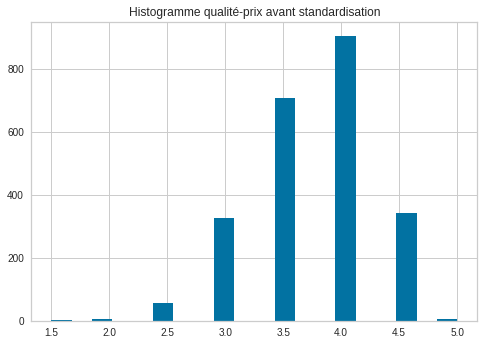

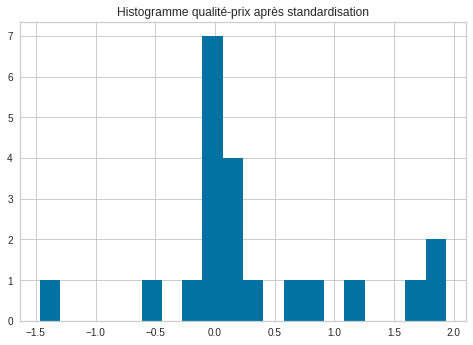

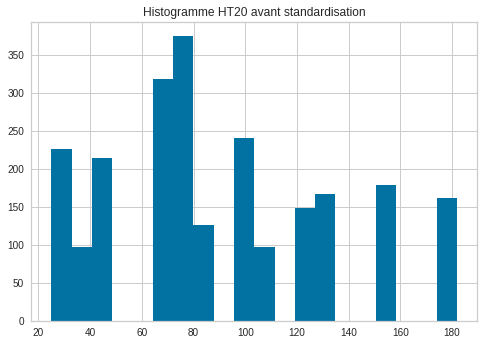

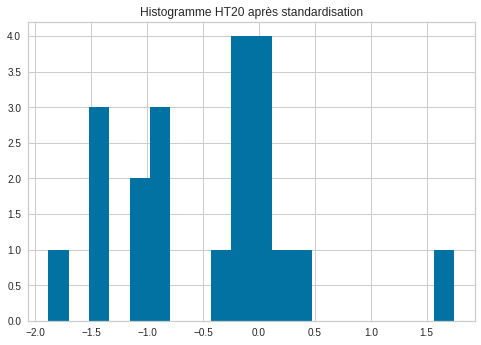

In [294]:
# nombre avis

plt.hist(dk["Nombre avis"],bins=20)
plt.title('Histogramme nombre avis avant standardisation')
plt.show()
plt.hist(Z[:][20],bins=20)
plt.title('Histogramme nombre avis après standardisation')
plt.show()

# note qualité-prix 

plt.hist(dk["Note qualité-prix"],bins=20)
plt.title('Histogramme qualité-prix avant standardisation')
plt.show()
plt.hist(Z[:][18],bins=20)
plt.title('Histogramme qualité-prix après standardisation')
plt.show()

# HT20

plt.hist(dk["HT20"],bins=20)
plt.title('Histogramme HT20 avant standardisation')
plt.show()
plt.hist(Z[:][4],bins=20)
plt.title('Histogramme HT20 après standardisation')
plt.show()

In [295]:
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)     # coordonnées factorielles

n=2352                               # nombre d'observations
eigval = (n-1)/n*acp.explained_variance_
print(eigval)                             # valeurs propres obtenues


[4.13122273e+00 3.90523734e+00 2.86552258e+00 1.67414788e+00
 1.60647971e+00 1.34232218e+00 1.05612373e+00 7.64151725e-01
 6.58866287e-01 5.24188454e-01 4.79762650e-01 4.35232523e-01
 4.09240648e-01 3.34370965e-01 2.05812122e-01 1.86594262e-01
 1.76966400e-01 1.10785167e-01 1.02830723e-01 2.72514768e-02
 2.89045134e-03]


In [296]:
#proportion de variance expliquée

print(acp.explained_variance_ratio_)


[1.96724892e-01 1.85963683e-01 1.36453456e-01 7.97213277e-02
 7.64990340e-02 6.39201038e-02 5.02916063e-02 3.63881774e-02
 3.13745851e-02 2.49613550e-02 2.28458405e-02 2.07253582e-02
 1.94876499e-02 1.59224269e-02 9.80057725e-03 8.88544106e-03
 8.42697144e-03 5.27548415e-03 4.89670110e-03 1.29768937e-03
 1.37640540e-04]


La première composante accapare 19.6% de l’information disponible, la deuxième 18,5%, la troisième 13.6%, la quatrième 7.97%... 
Nous disposons donc de  51.7% de l'inertie avec les trois premiers
facteurs.

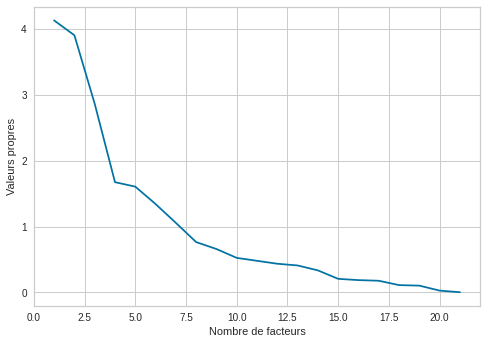

In [297]:
#graphique des valeurs propres par ordre décroissant
plt.plot(np.arange(1,22),eigval)
plt.ylabel("Valeurs propres")
plt.xlabel("Nombre de facteurs")
plt.show()

Combien de variables retenir ?

on peut construire pour cela le graphique du cumul de variance restituée selon le nombre de facteurs : 

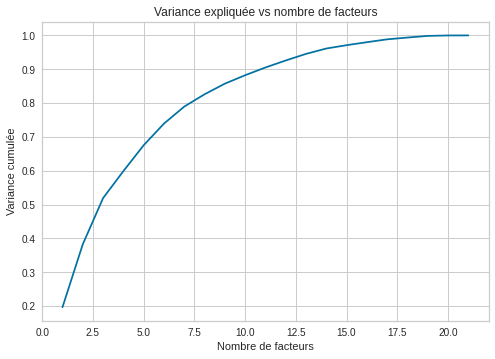

In [298]:
plt.plot(np.arange(1,22),np.cumsum(acp.explained_variance_ratio_))
plt.title("Variance expliquée vs nombre de facteurs")
plt.ylabel("Variance cumulée")
plt.xlabel("Nombre de facteurs")
plt.show()

On peut appliquer la "règle du coude" (les cassures de la courbe). Pour un nombre de facteurs égal à 3, on voit une légère cassure :


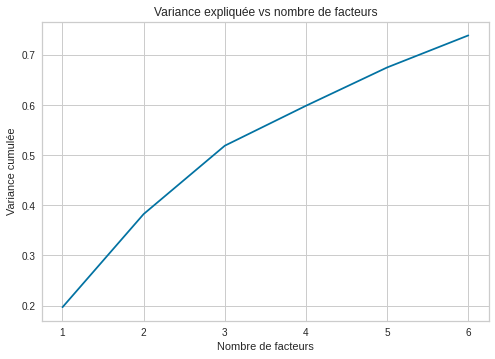

In [299]:
plt.plot(np.arange(1,7),np.cumsum(acp.explained_variance_ratio_)[:6])
plt.title("Variance expliquée vs nombre de facteurs")
plt.ylabel("Variance cumulée")
plt.xlabel("Nombre de facteurs")
plt.show()

La solution (K* = 3)
semble s’imposer ici.



D’autres pistes existent pour répondre à cette question toujours délicate de sélection du nombre de valeurs propres à retenir.
Par exemple, il existe le « test des bâtons brisés » de Legendre, qui nous dit qu'on retient le facteur k si il est supérieur à un certain seuil qu'on peut calculer facilement. Faisons-le : 

In [300]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(21,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

#test des bâtons brisés
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))



    Val.Propre    Seuils
0     4.131223  3.645359
1     3.905237  2.645359
2     2.865523  2.145359
3     1.674148  1.812025
4     1.606480  1.562025
5     1.342322  1.362025
6     1.056124  1.195359
7     0.764152  1.052502
8     0.658866  0.927502
9     0.524188  0.816390
10    0.479763  0.716390
11    0.435233  0.625481
12    0.409241  0.542148
13    0.334371  0.465225
14    0.205812  0.393796
15    0.186594  0.327130
16    0.176966  0.264630
17    0.110785  0.205806
18    0.102831  0.150251
19    0.027251  0.097619
20    0.002890  0.047619


Ici, le test confirme notre observation graphique : seules les 3 premières valeurs propres sont au-dessus de leur seuil associé. On retient donc 3 valeurs propres.

Maintenant, la question est de savoir quell est la signification de ces 3 axes. On trace pour cela le cercle des corrélations.

Nous avons besoin des vecteurs propres pour l’analyse des variables. Ils sont fournis par le champ .components_, ainsi que des racines des valeurs propres.

In [301]:
#racine carrée des valeurs propres

sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
correl = np.zeros((21,21))
for k in range(21):
  correl[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#on affiche pour les trois premiers axes par exemple
print(pd.DataFrame({'variable':dg.columns,'COR_1':correl[:,0],'COR_2':correl[:,1],'COR_3':correl[:,2]}))


                 variable     COR_1     COR_2     COR_3
0              Prix moyen -0.183106  0.094434  0.066566
1   Niveau de vie Commune  0.170509  0.816304  0.031235
2              Superficie -0.083654 -0.369165 -0.278799
3                    PTOT -0.182119 -0.706673 -0.429928
4                    HT20  0.077797  0.623608 -0.757235
5                   HT120 -0.098163 -0.202353 -0.280525
6                   HT220 -0.080513 -0.146720 -0.712527
7                   HT320 -0.009497  0.317539 -0.861017
8                   HT420  0.153036  0.853439 -0.416997
9                   HT520  0.200929  0.780354  0.010616
10                   RT20 -0.112409 -0.370008 -0.612764
11           nb_emeraudes -0.166531 -0.627881 -0.353221
12           categorySize  0.393829 -0.006747 -0.009624
13            employeesNb  0.291126 -0.091158  0.009703
14         Capital Social  0.297982 -0.082740  0.006448
15           Note Globale -0.906567  0.192078  0.052253
16        Note de cuisine -0.885941  0.183277  0

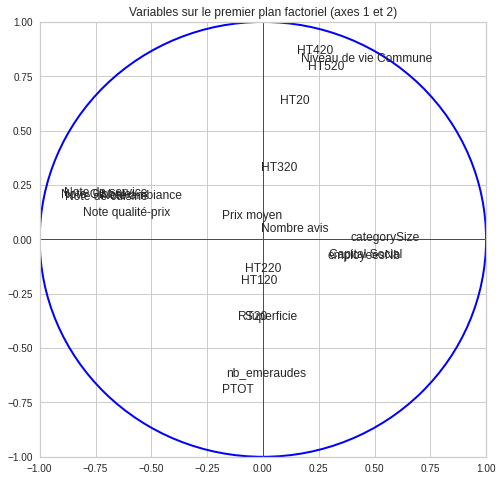

In [308]:
# on peut maintenant tracer notre cercle des corrélations

fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

#affichage des étiquettes (noms des variables)
for j in range(21):
 plt.annotate(dg.columns[j],(correl[j,0],correl[j,1]))

#ajout des axes

plt.plot([-1,1],[0,0],color='red',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='red',linestyle='-',linewidth=1)
plt.title("Variables sur le premier plan factoriel (axes 1 et 2)")

#ajout du cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False, linewidth=2)
axes.add_artist(cercle)

#affichage
plt.show()


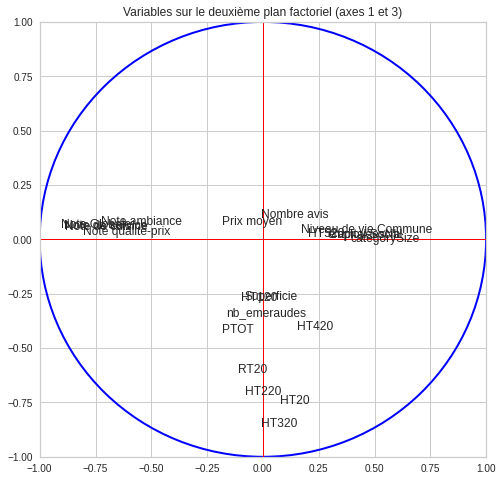

In [309]:
# sur le 2ème plan factoriel

fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(21):
  plt.annotate(dg.columns[j],(correl[j,0],correl[j,2]))

#ajout des axes

plt.plot([-1,1],[0,0],color='red',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='red',linestyle='-',linewidth=1)
plt.title("Variables sur le deuxième plan factoriel (axes 1 et 3)")

#ajout du cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False,linewidth=2)
axes.add_artist(cercle)

#affichage
plt.show()

Apparemment, le premier axe isole nos cinq variables de note (note d'ambiance, de service, de rapport qualité-prix, de cuisine, note globale) , le deuxième sépare davantage des variables externes au restaurants : HT420, HT520 et niveau de vie de la commune. Le troisième isole également des variables externes, notamment HT320.

In [310]:
# on calcule les cos² pour avoir la qualité de représentation des variables sur chaque axe

cos2var = correl**2
print(pd.DataFrame({'variable':dg.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1],'COS2_3':cos2var[:,2]}))

                 variable    COS2_1    COS2_2    COS2_3
0              Prix moyen  0.033528  0.008918  0.004431
1   Niveau de vie Commune  0.029073  0.666353  0.000976
2              Superficie  0.006998  0.136283  0.077729
3                    PTOT  0.033167  0.499387  0.184838
4                    HT20  0.006052  0.388887  0.573405
5                   HT120  0.009636  0.040947  0.078694
6                   HT220  0.006482  0.021527  0.507694
7                   HT320  0.000090  0.100831  0.741350
8                   HT420  0.023420  0.728359  0.173886
9                   HT520  0.040372  0.608952  0.000113
10                   RT20  0.012636  0.136906  0.375480
11           nb_emeraudes  0.027732  0.394234  0.124765
12           categorySize  0.155101  0.000046  0.000093
13            employeesNb  0.084755  0.008310  0.000094
14         Capital Social  0.088793  0.006846  0.000042
15           Note Globale  0.821864  0.036894  0.002730
16        Note de cuisine  0.784892  0.033590  0

Conformément à ce qui a été vu graphiquement : 

- pour le premier axe : Note globale, note de cuisine et note de service sont bien représentées ; ce sont des critères internes au restaurant, et des critères de jugement

- pour le deuxième axe : HT420, Niveau de vie de la commune sont bien représentés

- pour le troisième axe : HT320 est bien représenté

Enfin, concernant l'ACP sur les individus (= des restaurants ici), représentés sur le premier plan factoriel :


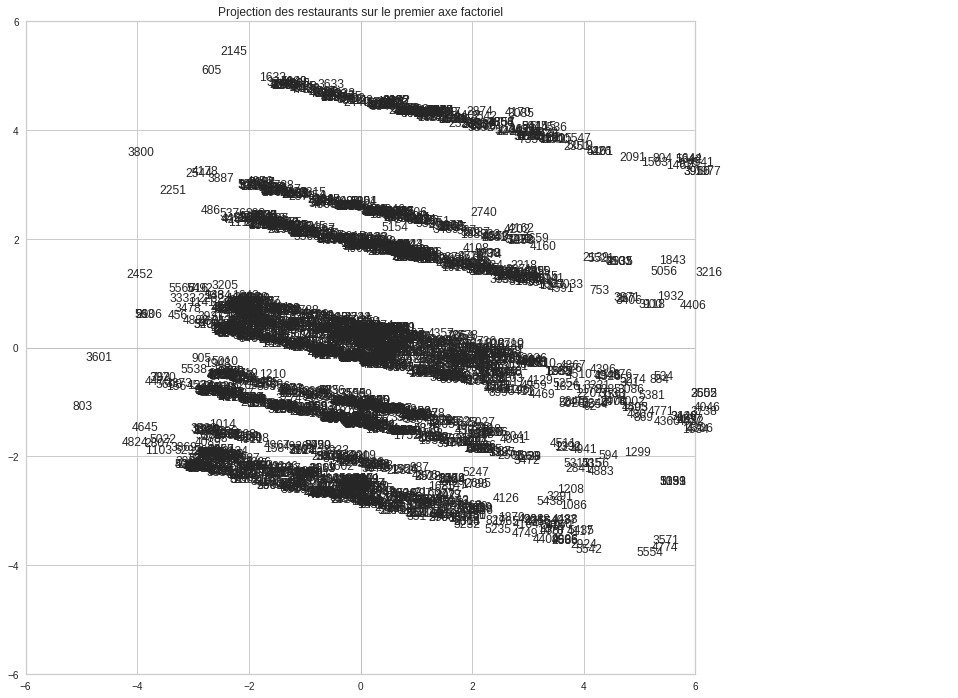

In [318]:
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) 
axes.set_ylim(-6,6) 
for i in range(n):
 plt.annotate(dg.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
plt.title("Projection des restaurants sur le premier axe factoriel")
#affichage
plt.show()

On voit qu'il semble se distinguer 5 à 6 groupes de restaurant. Cela peut nous mettre sur la piste d'un clustering, du type k-means (avec k=5/6). Creusons cette piste... 

On voit également la présence d'un certain nombre d'outliers (environ une dizaine, surtout sur le côté gauche). Peut-être faudra-t-il les retirer des données...

### Clustering

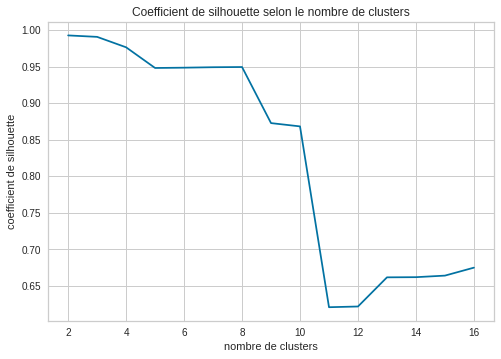

In [319]:
from sklearn.cluster import KMeans
from sklearn import metrics

# on va faire varier le nombre de clusters de 2 à 16 et voir quel nombre nous permet la meilleure partition au sens de la métrique "silhouette" (dans sklearn)
res = np.arange(15,dtype="double")
for k in np.arange(15):
  km = KMeans(n_clusters=k+2)
  km.fit(dk)
  res[k] = metrics.silhouette_score(dk,km.labels_)


# graphique

plt.title("Coefficient de silhouette selon le nombre de clusters")
plt.xlabel("nombre de clusters")
plt.ylabel("coefficient de silhouette")
plt.plot(np.arange(2,17,1),res)
plt.show()




La partition en k=2 classes semble la meilleure au sens de la métrique silhouette. On va ajouter la variable label1 stockant le résultat de cette typologie.

In [66]:
dk_clust=dk.copy(deep="True")

km = KMeans(n_clusters=2)
km.fit(dk)

dk_clust["label1"]=km.labels_

In [67]:
 # Si l'on s'intéresse plus précisément à la répartition dans ces deux clusters :

 dk_clust["label1"].value_counts()

0    2344
1       8
Name: label1, dtype: int64

Aie ! Il semble bien qu'il y ait là présence d'outliers dans nos données ! Est-ce-que ce sont ceux qu'on a identifié dans notre plan factoriel de l'ACP précédente ?

In [68]:
# méthode non graphique : on récupère les numéros d'indices correspondant au label 1

dk_clust[dk_clust["label1"]==1]

,Prix moyen,Niveau de vie Commune,Superficie,PTOT,HT20,HT120,HT220,HT320,HT420,HT520,RT20,nb_emeraudes,categorySize,employeesNb,Capital Social,Note Globale,Note de cuisine,Note de service,Note qualité-prix,Note ambiance,Nombre avis,label1
594,7.5,31804.666667,181.0,16395.0,74.0,1.0,4.0,21.0,28.0,14.0,3.0,0,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
1449,7.5,26820.952381,560.0,136941.0,99.0,3.0,15.0,49.0,15.0,0.0,2.0,4,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
4697,7.5,20246.500000,604.0,196131.0,67.0,2.0,10.0,23.0,12.0,0.0,5.0,4,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
7386,7.5,30322.000000,116.0,34389.0,31.0,0.0,4.0,9.0,9.0,2.0,0.0,2,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
8801,7.5,30203.043478,846.0,235178.0,98.0,1.0,9.0,60.0,23.0,0.0,7.0,3,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
9604,7.5,22993.809524,713.0,183399.0,48.0,0.0,8.0,25.0,9.0,0.0,6.0,4,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
11823,7.5,24242.857143,288.0,90836.0,120.0,0.0,22.0,50.0,15.0,1.0,3.0,2,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1
13096,7.5,20076.666667,596.0,196739.0,26.0,1.0,4.0,12.0,0.0,0.0,3.0,2,2.0,2119.0,134104380.0,2.5,3.0,2.5,3.0,2.5,105.0,1


On voit qu'il s'agit de restaurants...aux mêmes caractéristiques !
Voyons à quoi ce restaurant correspond : 

In [71]:
parisiens.iloc[1449]

legalImmat                                                           380744870
streetNumber                                                                 4
streetName                                                  AVENUE JEAN MOULIN
Code Postal                                                              75014
city                                                                  PARIS 14
isHeadquarters                                                               0
legalName                                                       KFC FRANCE SAS
legalStructure                                                             SAS
employeesNb                                                               2119
categorySize                                                                 2
foundingYear                                                              1991
sourceLastUpdate                                           2010-04-15T00:00:00
name                                                

In [70]:
parisiens.iloc[1449]["Lien TripAdvisor"]

'https://www.tripadvisor.fr/Restaurant_Review-g187147-d948611-Reviews-KFC-Paris_Ile_de_France.html'

En fait, les 8 donées précédentes font référence à la même compagnie "KFC France SAS". Il s'agit donc de répétitions dans notre table de données de base. 

Les données nous disent que cet établissement "KFC France SAS", qui est spécialisé dans le secteur d'activité de la restauration de type rapide, est une grosse société (de capital social élevé) qui regroupe sous sa coupe les restaurants de type KFC. Peut-être donc est-il présent dans la table autant de fois qu'il y a de restaurants KFC à Paris. En se renseignant sur Internet, il y a 12 restaurants KFC à Paris aujourd'hui (donc probablement 8 en 2010, date à laquelle la dernière mise à jour a été effectuée, on le voit dans "sourceLastUpdate" du tableau précédent).

On décide donc de supprimer ces doublons (qui ont le même numéro de siren), et de manière générale tous les établissements qui ont le même numéro de siren (on aurait pu le faire avant, mais étions persuadés que le numéro de siren identifiat de manière unique un restaurant) 

In [320]:
par=parisiens.drop_duplicates(subset = ['legalImmat'])

In [321]:
par

,legalImmat,streetNumber,streetName,Code Postal,city,isHeadquarters,legalName,legalStructure,employeesNb,categorySize,foundingYear,sourceLastUpdate,name,dep,Code INSEE,Département,Région,Altitude Moyenne,Superficie,PTOT,Niveau de vie Commune,Niveau de vie Département,HT20,HT120,HT220,HT320,HT420,HT520,CPG20,RT20,arr,nb_emeraudes,Capital Social,Lien TripAdvisor,Style de nourriture,Note Globale,Catégorie de prix,Note de cuisine,Note de service,Note qualité-prix,Note ambiance,Nombre avis,Prix inf,Prix sup,Prix moyen
0,304305519,5.0,AVENUE DU MAINE,75015,PARIS 15,1,LES CEDRES DU LIBAN,SARL,6.0,1.0,1973,2014-07-05T00:00:00,LES CEDRES DU LIBAN,75,75115.0,PARIS,ILE-DE-FRANCE,40.0,846.0,235178.0,30203.043478,27171.253619,98.0,1.0,9.0,60.0,23.0,0.0,0.0,7.0,15,3,7622.45,https://www.tripadvisor.fr/Restaurant_Review-g...,Saine,4.5,moyen,4.5,4.5,4.0,3.5,850.0,8.0,21.0,14.5
1,306332362,25.0,RUE DE LA HUCHETTE,75005,PARIS 5,1,LE SOUVLAKI ATHENIEN,SARL,0.0,1.0,1900,1991-02-05T00:00:00,LE SOUVLAKI ATHENIEN,75,75105.0,PARIS,ILE-DE-FRANCE,42.0,252.0,59631.0,32336.000000,27171.253619,84.0,1.0,14.0,35.0,24.0,0.0,0.0,3.0,5,4,54881.65,https://www.tripadvisor.fr/Restaurant_Review-g...,NaN,4.0,faible,4.0,4.0,4.0,4.0,59.0,4.0,15.0,9.5
2,307711895,15.0,PLACE DU TERTRE,75018,PARIS 18,1,LA CREMAILLERE DE MONTMARTRE,SAS,20.0,1.0,1976,2015-09-11T00:00:00,LA CREMAILLERE DE MONTMARTRE,75,75118.0,PARIS,ILE-DE-FRANCE,57.0,604.0,196131.0,20246.500000,27171.253619,67.0,2.0,10.0,23.0,12.0,0.0,0.0,5.0,18,4,99220.80,https://www.tripadvisor.fr/Restaurant_Review-g...,NaN,3.5,moyen,3.5,3.5,3.5,4.0,1036.0,17.0,37.0,27.0
3,318906591,11.0,RUE DE L ARRIVEE,75015,PARIS 15,0,LA BRIOCHE DOREE,SAS,1900.0,2.0,1980,2010-04-15T00:00:00,LA BRIOCHE DOREE,75,75115.0,PARIS,ILE-DE-FRANCE,40.0,846.0,235178.0,30203.043478,27171.253619,98.0,1.0,9.0,60.0,23.0,0.0,0.0,7.0,15,3,95000000.00,https://www.tripadvisor.fr/Restaurant_Review-g...,Restauration rapide,4.0,faible,4.0,3.5,4.0,3.5,421.0,NaN,NaN,NaN
4,319947537,14.0,RUE MABILLON,75006,PARIS 6,1,BRASSERIE DE LA GRILLE SAINT-GERMAIN,SAS,18.0,1.0,1980,2013-01-15T00:00:00,BRASSERIE DE LA GRILLE SAINT GERMAIN,75,75106.0,PARIS,ILE-DE-FRANCE,40.0,215.0,41976.0,39079.000000,27171.253619,105.0,1.0,10.0,40.0,33.0,7.0,0.0,4.0,6,1,41700.00,https://www.tripadvisor.fr/Restaurant_Review-g...,NaN,3.0,moyen,3.0,3.5,3.0,3.5,336.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13273,822182333,53.0,RUE DU MONTPARNASSE,75014,PARIS 14,1,DIBOUILLE,SASU,NaN,NaN,2016,2016-09-07T00:00:00,DIBOUILLE,75,75114.0,PARIS,ILE-DE-FRANCE,63.0,560.0,136941.0,26820.952381,27171.253619,99.0,3.0,15.0,49.0,15.0,0.0,0.0,2.0,14,4,5000.00,https://www.tripadvisor.fr/Restaurant_Review-g...,NaN,4.0,moyen,4.0,4.5,4.0,3.5,236.0,NaN,NaN,NaN
13275,823268370,17.0,RUE VIGNON,75008,PARIS 8,1,HU JIN,SARL,NaN,NaN,2016,2016-12-06T00:00:00,HU JIN,75,75108.0,PARIS,ILE-DE-FRANCE,39.0,385.0,37368.0,40140.666667,27171.253619,152.0,1.0,5.0,39.0,60.0,36.0,0.0,3.0,8,1,3000.00,https://www.tripadvisor.fr/Restaurant_Review-g...,Asiatique,4.0,élevé,4.5,4.5,3.5,3.5,167.0,NaN,NaN,NaN
13276,823628706,115.0,BOULEVARD DAVOUT,75020,PARIS 20,1,YASMINE D'ORIENT,SARL,NaN,NaN,2016,2016-12-13T00:00:00,YASMINE D'ORIENT,75,75120.0,PARIS,ILE-DE-FRANCE,80.0,596.0,196739.0,20076.666667,27171.253619,26.0,1.0,4.0,12.0,0.0,0.0,0.0,3.0,20,2,7500.00,https://www.tripadvisor.fr/Restaurant_Review-g...,Végétariens bienvenus,4.0,faible,4.0,4.0,4.0,4.0,288.0,NaN,NaN,NaN
13277,823812573,248.0,RUE DU FBG ST ANTOINE,75012,PARIS 12,1,CHEZ XIA,SAS,NaN,NaN,2016,2016-12-09T00:00:00,CHEZ XIA,75,75112.0,PARIS,ILE-DE-FRANCE,49.0,1636.0,141287.0,26477.785714,27171.253619,79.0,1.0,13.0,35.0,13.0,0.0,0.0,6.0,12,3,6000.00,https://www.tripadvisor.fr/Restaurant_Review-g...,NaN,2.5,faible,3.0,3.0,3.0,NaN,27.0,NaN,NaN,NaN


In [322]:
# on reconstruit tous nos dataframes (mention "bis")

dfbis=par[["Prix moyen","Niveau de vie Commune","Superficie","PTOT","HT20","HT120","HT220",
              "HT320","HT420","HT520","RT20","nb_emeraudes","categorySize","employeesNb","Capital Social",
              "Note Globale","Note de cuisine","Note de service","Note qualité-prix","Note ambiance","Nombre avis"]]

dgbis=dfbis[dfbis['Prix moyen'] < 2000]

dhbis=dgbis[["Prix moyen","PTOT","HT20","HT520","nb_emeraudes","Capital Social","Note qualité-prix","Note ambiance","Nombre avis"]]

dkbis=dgbis.dropna(how="any")
dkbis.shape


(2090, 21)

Les résultats sur les régressions linéaires ne changent pas. De plus, les résultats de l'ACP sont également peu modifiés : 

In [324]:
sc = StandardScaler()
Z = sc.fit_transform(dkbis)

acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)     # coordonnées factorielles

n=2090                               # nombre d'observations
eigval = (n-1)/n*acp.explained_variance_
print(eigval)                             # valeurs propres obtenues


[3.96106860e+00 3.87629501e+00 2.80824096e+00 1.62641816e+00
 1.61189017e+00 1.34705534e+00 1.06564256e+00 7.98583242e-01
 7.43615555e-01 5.32996766e-01 5.21091353e-01 5.07803657e-01
 4.14545630e-01 3.37679378e-01 2.17539423e-01 1.94430516e-01
 1.84700440e-01 1.17407910e-01 1.02410378e-01 2.76024262e-02
 2.98252064e-03]


In [325]:
#proportion de variance expliquée

print(acp.explained_variance_ratio_)

[1.88622314e-01 1.84585477e-01 1.33725760e-01 7.74484838e-02
 7.67566748e-02 6.41454925e-02 5.07448838e-02 3.80277734e-02
 3.54102645e-02 2.53807984e-02 2.48138740e-02 2.41811265e-02
 1.97402681e-02 1.60799704e-02 1.03590201e-02 9.25859601e-03
 8.79525904e-03 5.59085287e-03 4.87668468e-03 1.31440125e-03
 1.42024792e-04]


La première composante accapare 18.9% de l’information disponible, la deuxième 18,4%, la troisième 13.4%, la quatrième 7.7%... 
Nous disposons donc de  50.7% de l'inertie avec les trois premiers
facteurs.

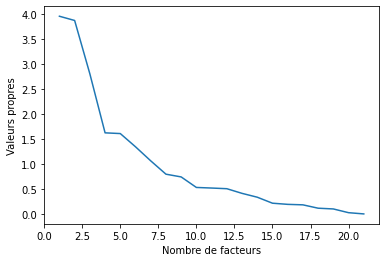

In [88]:
#graphique des valeurs propres par ordre décroissant
plt.plot(np.arange(1,22),eigval)
plt.ylabel("Valeurs propres")
plt.xlabel("Nombre de facteurs")
plt.show()

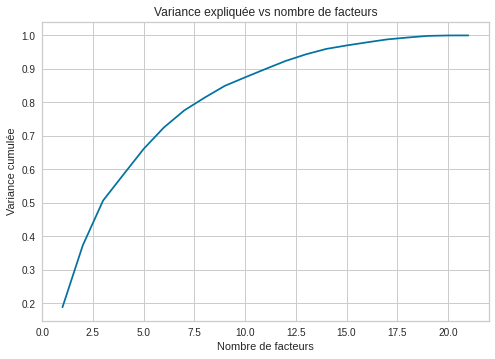

In [326]:
plt.plot(np.arange(1,22),np.cumsum(acp.explained_variance_ratio_))
plt.title("Variance expliquée vs nombre de facteurs")
plt.ylabel("Variance cumulée")
plt.xlabel("Nombre de facteurs")
plt.show()

In [328]:
#racine carrée des valeurs propres

sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
correl = np.zeros((21,21))
for k in range(21):
    correl[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#on affiche pour les trois premiers axes par exemple
print(pd.DataFrame({'variable':dg.columns,'COR_1':correl[:,0],'COR_2':correl[:,1],'COR_3':correl[:,2]}))

                 variable     COR_1     COR_2     COR_3
0              Prix moyen -0.070166 -0.180291  0.092917
1   Niveau de vie Commune  0.630919 -0.542707  0.043142
2              Superficie -0.303126  0.229008 -0.252305
3                    PTOT -0.588710  0.437132 -0.414936
4                    HT20  0.439665 -0.469286 -0.747420
5                   HT120 -0.193709  0.105555 -0.279948
6                   HT220 -0.158936  0.034334 -0.716087
7                   HT320  0.181666 -0.294825 -0.855831
8                   HT420  0.643823 -0.588087 -0.401243
9                   HT520  0.640742 -0.480832  0.040004
10                   RT20 -0.328879  0.220730 -0.584041
11           nb_emeraudes -0.518288  0.370677 -0.372213
12           categorySize  0.200252  0.147192  0.003954
13            employeesNb  0.079147  0.114723  0.012995
14         Capital Social  0.116368  0.100062  0.044085
15           Note Globale -0.601155 -0.710745  0.074834
16        Note de cuisine -0.591695 -0.695484  0

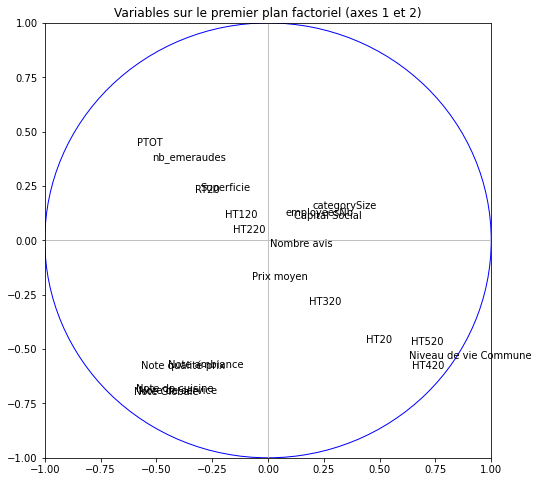

In [ ]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

#affichage des étiquettes (noms des variables)
for j in range(21):
    plt.annotate(dg.columns[j],(correl[j,0],correl[j,1]))

#ajout des axes

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
plt.title("Variables sur le premier plan factoriel (axes 1 et 2)")

#ajout du cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()

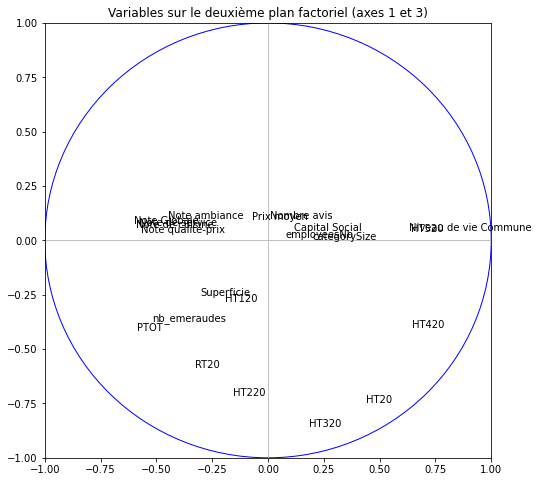

In [ ]:
# sur le 2ème plan factoriel

fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

for j in range(21):
    plt.annotate(dg.columns[j],(correl[j,0],correl[j,2]))

#ajout des axes

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
plt.title("Variables sur le deuxième plan factoriel (axes 1 et 3)")

#ajout du cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()

On voit que pour le premier plan factoriel, les conclusions changent un peu :

- le 1er axe isole HT420, HT520 et le niveau vie de la commune (alors que pour l'ACP précédente, c'était le deuxième axe qui isolait ces variables)

- pour le 2ème axe : Note globale, note de cuisine et note de service sont bien représentées ; dans l'ACP précédente, il s'agissait du 1er axe qui les isolait.


- les conclusions pour le troisième axe restent inchangées (HT320 est bien représenté)

En outre, on a eu en quelque sorte une "inversion" des deux axes, ce qui est confirmé par l'ACP sur les individus (les restaurants): 


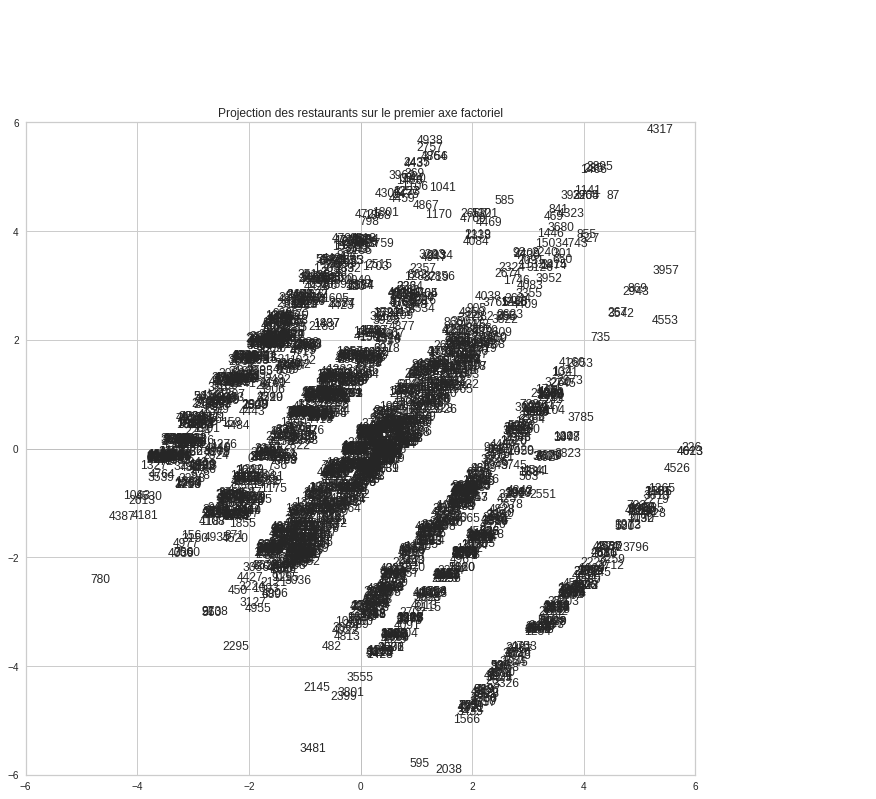

In [329]:
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) 
axes.set_ylim(-6,6) 
for i in range(n):
    plt.annotate(dg.index[i],(coord[i,0],coord[i,1]))
    
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
plt.title("Projection des restaurants sur le premier axe factoriel")

#affichage
plt.show()

Les strates sont dans l'autre sens que l'ACP précédente. Cela confirme le fait que les deux axes du premier plan factoriel sont inversés par rapport à la situation précédente. On a 5 groupes qui semblent se former.

Repassons au clustering : 

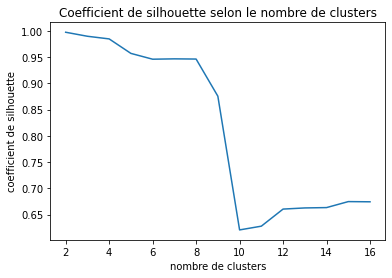

In [96]:
res = np.arange(15,dtype="double")
for k in np.arange(15):
    km = KMeans(n_clusters=k+2)
    km.fit(dkbis)
    res[k] = metrics.silhouette_score(dkbis,km.labels_)


# graphique

plt.title("Coefficient de silhouette selon le nombre de clusters")
plt.xlabel("nombre de clusters")
plt.ylabel("coefficient de silhouette")
plt.plot(np.arange(2,17,1),res)
plt.show()

k=2 semble toujours être le nombre de classes à choisir selon ce critère silhouette.

Si on regarde selon le critère du coude : 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f99747dbe10>,
                 k=None, metric=None, model=None, timings=True)

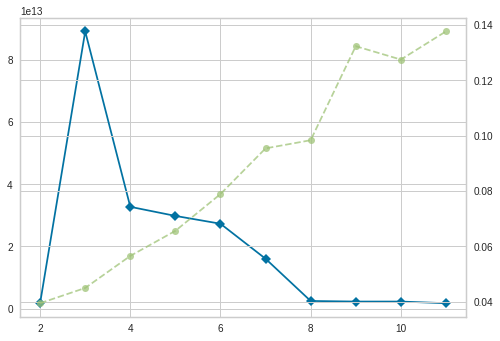

In [97]:
from yellowbrick.cluster import KElbowVisualizer

model= KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(dkbis)

Selon le critère du coude, K=3 semble être le bon nombre de classes à choisir. 

On choisit pour la suite d'introduire deux variables label3 et label6 stockant les résultats de la typologie pour k=3 (mis en évidence par méthode du coude) et k=6 (nombre de groupes qui semble apparaître en faisant l'ACP)

In [98]:
dkbis_clust=dkbis.copy(deep="True")

km1 = KMeans(n_clusters=3)
km1.fit(dkbis)

dkbis_clust["label3"]=km1.labels_

km2 = KMeans(n_clusters=6)
km2.fit(dkbis)

dkbis_clust["label6"]=km2.labels_

In [100]:
# on regarde la répartition dans chaque cluster

print(dkbis_clust["label3"].value_counts())
print(dkbis_clust["label6"].value_counts())


0    2084
2       5
1       1
Name: label3, dtype: int64
0    2064
5      16
4       4
3       3
2       2
1       1
Name: label6, dtype: int64


On a la même répartition que tout à l'heure : le premier cluster est très rempli, et les autres sont minoritaires !
En fait, il s'agit d'n problème de standardisation : le capital social a une distribution qui écrase celle des autres variables. On le voit en faisant la moyenne du capital social au sein de chaque cluster : 

In [117]:
print(dkbis_clust.groupby("label3").mean()["Capital Social"])
print(dkbis_clust.groupby("label6").mean()["Capital Social"])




label3
0    7.174012e+04
1    1.341044e+08
2    2.385120e+07
Name: Capital Social, dtype: float64
label6
0    3.424687e+04
1    1.341044e+08
2    3.457581e+07
3    1.670146e+07
4    9.260160e+06
5    2.611265e+06
Name: Capital Social, dtype: float64


La moyenne du capital social dans les clusters 0 est presque 100 à 10 000 fois plus forte que dans les autres clusters.

In [145]:
# standardisation des données, comme dans notre ACP normée

sc = StandardScaler()
Z = sc.fit_transform(dkbis)
Z=pd.DataFrame(Z,index=dkbis.index,columns=dkbis.columns)

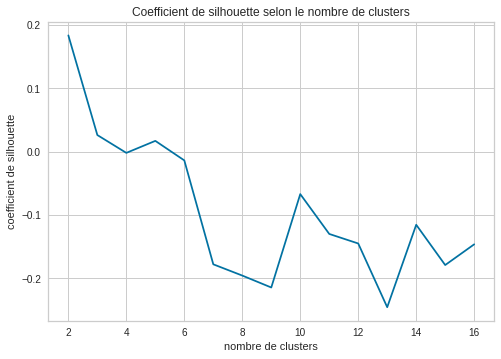

In [146]:
res = np.arange(15,dtype="double")
for k in np.arange(15):
    km = KMeans(n_clusters=k+2,max_iter=600)
    km.fit(Z)
    res[k] = metrics.silhouette_score(dkbis,km.labels_)


# graphique

plt.title("Coefficient de silhouette selon le nombre de clusters")
plt.xlabel("nombre de clusters")
plt.ylabel("coefficient de silhouette")
plt.plot(np.arange(2,17,1),res)
plt.show()


Là encore, le critère de silhouette nous indique k=2

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f99710c6cf8>,
                 k=None, metric=None, model=None, timings=True)

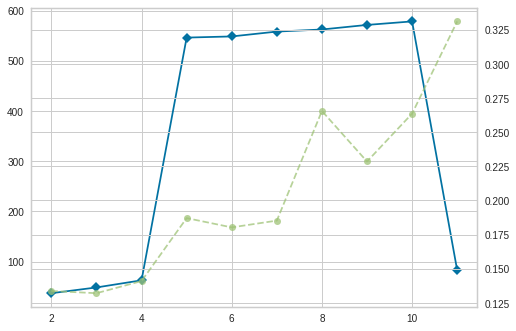

In [147]:
# avec critère du coude

model= KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(Z)

La méthode semble nous indiquer k=5.

On choisit comme précédemment d'introduire deux variables label2 et label5 stockant les résultats de la typologie pour k=2 (mis en évidence par méthode du critère de silhouette) et k=5 ( mis en évidence par la méthode du coude et également nombre de groupes qui semble apparaître en faisant l'ACP).


In [148]:
Z_clust=Z.copy(deep="True")

km1 = KMeans(n_clusters=2)
km1.fit(Z)

Z_clust["label2"]=km1.labels_

km2 = KMeans(n_clusters=5)
km2.fit(Z)

Z_clust["label5"]=km2.labels_

In [149]:
# on regarde la répartition dans chaque cluster

print(Z_clust["label2"].value_counts())
print(Z_clust["label5"].value_counts())

1    1199
0     891
Name: label2, dtype: int64
2    605
4    594
1    398
0    343
3    150
Name: label5, dtype: int64


Les effectifs au sein de chaque cluster sont plus homogènes. Mainteant, toute la question est de savoir : qu'est-ce-qui caractérise ces classes ? Cela revient à faire des statistiques descriptives sur chacun des clusters

### Pour le cas à 2 clusters : 

In [169]:
print(Z_clust.groupby("label2").mean()["Capital Social"])
print(Z_clust.groupby("label2").mean()["Nombre avis"])
print(Z_clust.groupby("label2").mean()["PTOT"])
print(Z_clust.groupby("label2").mean()["Note Globale"])
print(Z_clust.groupby("label2").mean()["HT420"])
print(Z_clust.groupby("label2").mean()["Niveau de vie Commune"])
print(Z_clust.groupby("label2").mean()["Prix moyen"])
print(Z_clust.groupby("label2").mean()["Note qualité-prix"])

label2
0    0.038389
1   -0.028528
Name: Capital Social, dtype: float64
label2
0    0.038945
1   -0.028941
Name: Nombre avis, dtype: float64
label2
0   -0.863769
1    0.641883
Name: PTOT, dtype: float64
label2
0   -0.011398
1    0.008470
Name: Note Globale, dtype: float64
label2
0    0.577998
1   -0.429521
Name: HT420, dtype: float64
label2
0    0.827519
1   -0.614945
Name: Niveau de vie Commune, dtype: float64
label2
0    0.049133
1   -0.036512
Name: Prix moyen, dtype: float64
label2
0   -0.058911
1    0.043778
Name: Note qualité-prix, dtype: float64


En première observation, avec ces moyennes, on voit que le cluster numéro 0 se caractérise par des restaurants dans des arrondissements aisés, peu peuplés et touristiques, au contraire du cluster 1. 
Il y a discrimination ici au niveau de facteurs géographiques

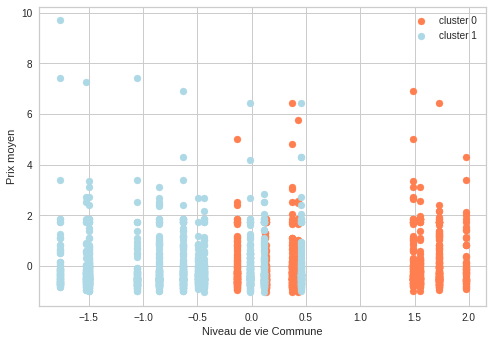

In [166]:
# graphiquement 

X1=Z_clust[Z_clust["label2"]==0]["Niveau de vie Commune"]
X2=Z_clust[Z_clust["label2"]==1]["Niveau de vie Commune"]
Y1=Z_clust[Z_clust["label2"]==0]["Prix moyen"]
Y2=Z_clust[Z_clust["label2"]==1]["Prix moyen"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('Niveau de vie Commune')
plt.ylabel('Prix moyen')
plt.legend()
plt.show()

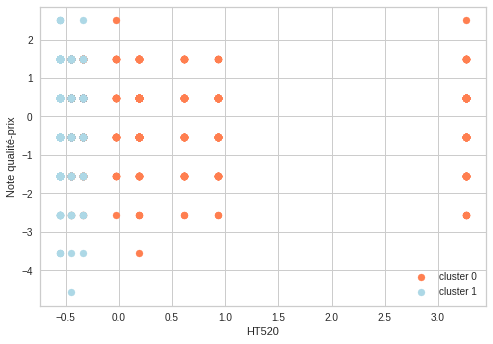

In [170]:
X1=Z_clust[Z_clust["label2"]==0]["HT520"]
X2=Z_clust[Z_clust["label2"]==1]["HT520"]
Y1=Z_clust[Z_clust["label2"]==0]["Note qualité-prix"]
Y2=Z_clust[Z_clust["label2"]==1]["Note qualité-prix"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('HT520')
plt.ylabel('Note qualité-prix')
plt.legend()
plt.show()

On voit que la dispersion au sein du cluster 1 est élevée, tout du moins concernant la variable HT520.

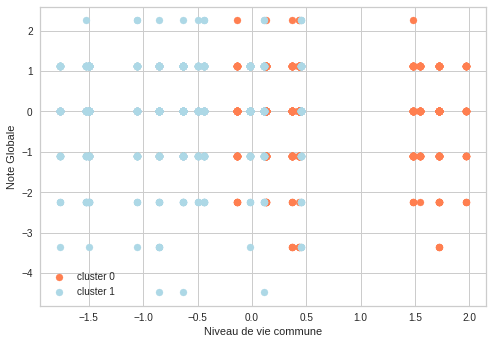

In [174]:
X1=Z_clust[Z_clust["label2"]==0]["Niveau de vie Commune"]
X2=Z_clust[Z_clust["label2"]==1]["Niveau de vie Commune"]
Y1=Z_clust[Z_clust["label2"]==0]["Note Globale"]
Y2=Z_clust[Z_clust["label2"]==1]["Note Globale"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('Niveau de vie commune')
plt.ylabel('Note Globale')
plt.legend()
plt.show()

Ce clustering à deux clusters est surtout discriminant sur les variables géographiques : niveau de vie, population, arrondissement touristique ou non... Par contre, il ne discrimine pas des facteurs internes type note, capital social, ou prix moyen, qui nécessitent un affinage avec plus de clusters.

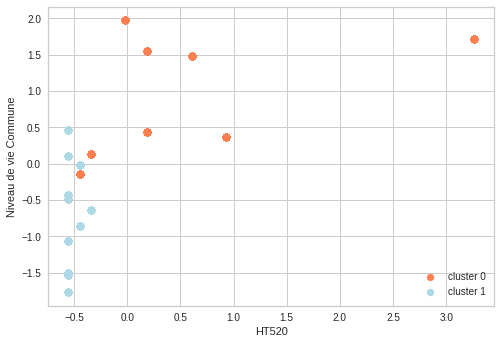

In [179]:
# avec deux variables "géographiques" 

X1=Z_clust[Z_clust["label2"]==0]["HT520"]
X2=Z_clust[Z_clust["label2"]==1]["HT520"]
Y1=Z_clust[Z_clust["label2"]==0]["Niveau de vie Commune"]
Y2=Z_clust[Z_clust["label2"]==1]["Niveau de vie Commune"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('HT520')
plt.ylabel('Niveau de vie Commune')
plt.legend()
plt.show()


Les clusters sont assez isolés

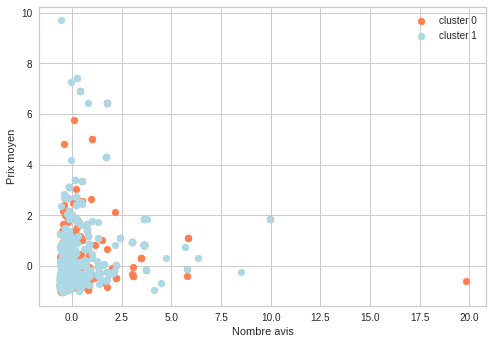

In [180]:
# avec deux variables "internes"

X1=Z_clust[Z_clust["label2"]==0]["Nombre avis"]
X2=Z_clust[Z_clust["label2"]==1]["Nombre avis"]
Y1=Z_clust[Z_clust["label2"]==0]["Prix moyen"]
Y2=Z_clust[Z_clust["label2"]==1]["Prix moyen"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('Nombre avis')
plt.ylabel('Prix moyen')
plt.legend()
plt.show()

Très mauvais ici !

### Pour le cas à 5 clusters : 

In [183]:
# variables géographiques 
print(Z_clust.groupby("label5").mean()["PTOT"])
print(Z_clust.groupby("label5").mean()["HT420"])
print(Z_clust.groupby("label5").mean()["HT520"])
print(Z_clust.groupby("label5").mean()["HT320"])
print(Z_clust.groupby("label5").mean()["RT20"])
print(Z_clust.groupby("label5").mean()["Niveau de vie Commune"])

# variables internes
print(Z_clust.groupby("label5").mean()["Capital Social"])
print(Z_clust.groupby("label5").mean()["Nombre avis"])
print(Z_clust.groupby("label5").mean()["Note Globale"])
print(Z_clust.groupby("label5").mean()["Note ambiance"])
print(Z_clust.groupby("label5").mean()["Prix moyen"])
print(Z_clust.groupby("label5").mean()["Note qualité-prix"])

label5
0    0.436009
1   -1.192832
2    1.026152
3   -1.050024
4   -0.232529
Name: PTOT, dtype: float64
label5
0   -0.371093
1   -0.341846
2   -0.624005
3    2.387382
4    0.476019
Name: HT420, dtype: float64
label5
0   -0.336271
1    0.025010
2   -0.387928
3    3.263212
4   -0.251513
Name: HT520, dtype: float64
label5
0   -0.085817
1   -0.955792
2   -0.311949
3    0.065075
4    0.991260
Name: HT320, dtype: float64
label5
0    0.278972
1   -1.337287
2    0.931346
3   -0.277315
4   -0.143627
Name: RT20, dtype: float64
label5
0   -0.336288
1    0.362143
2   -0.626136
3    1.720618
4    0.154769
Name: Niveau de vie Commune, dtype: float64
label5
0    0.126896
1    0.014977
2   -0.046238
3   -0.024414
4   -0.030050
Name: Capital Social, dtype: float64
label5
0   -0.086648
1    0.164402
2    0.000411
3   -0.006396
4   -0.058924
Name: Nombre avis, dtype: float64
label5
0   -1.389364
1    0.084606
2    0.421307
3   -0.100969
4    0.341975
Name: Note Globale, dtype: float64
label5
0   -1.02485

En première observation, avec ces moyennes, on voit "en gros que :

- le cluster numéro 0 caractérise les restaurants ayant une Note Globale, une Note qualité-prix et une note d'ambiance faibles, ainsi qu'un prix moyen plus faible que le reste

- le cluster numéro 1 se caractérise par les restaurants dans les arrondissements à la fois peu peuplés, ayant peu de résidences de tourisme et récoltant en moyenne plus d'avis

- le cluster numéro 2 caractérise les restaurants ayant une Note Globale et une Note qualité-prix légèrement plus élevées, et dans des arrondissements peuplés, pauvres, ayant beaucoup de résidences de tourisme (RT20 élevé) mais pas luxueueses (peu d'hôtels étoilés)

- le cluster numéro 3 caractérise des restaurants situés dans des arrondissements très aisés, et pratiquant des prix légèrement plus élevés

- le dernier cluster (numéro 4) ne caractérise pas un cerain type de restaurants au vu des résultats, il constitue plus un intermédiaire entre tout le reste

Graphiquement : 

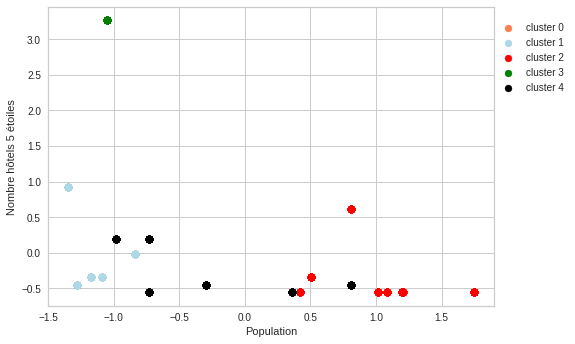

In [193]:
# 1 : croisement de variables géographiques 

X1=Z_clust[Z_clust["label5"]==0]["PTOT"]
X2=Z_clust[Z_clust["label5"]==1]["PTOT"]
X3=Z_clust[Z_clust["label5"]==2]["PTOT"]
X4=Z_clust[Z_clust["label5"]==3]["PTOT"]
X5=Z_clust[Z_clust["label5"]==4]["PTOT"]


Y1=Z_clust[Z_clust["label5"]==0]["HT520"]
Y2=Z_clust[Z_clust["label5"]==1]["HT520"]
Y3=Z_clust[Z_clust["label5"]==2]["HT520"]
Y4=Z_clust[Z_clust["label5"]==3]["HT520"]
Y5=Z_clust[Z_clust["label5"]==4]["HT520"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('Population')
plt.ylabel('Nombre hôtels 5 étoiles')
plt.legend(loc=(1,0.7))
plt.show()

Le cluster 3 caractérise effectivement des restaurants dans des arrondissements très aisés (beaucoup d'hôtels 5 étoiles).

Le cluster 2 caractérise bien des arrondissements peuplés, à la différence du cluster 1.

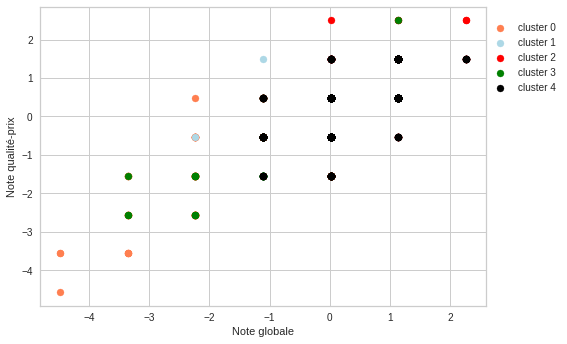

In [195]:
# 2 : croisement de varaibles internes

X1=Z_clust[Z_clust["label5"]==0]["Note Globale"]
X2=Z_clust[Z_clust["label5"]==1]["Note Globale"]
X3=Z_clust[Z_clust["label5"]==2]["Note Globale"]
X4=Z_clust[Z_clust["label5"]==3]["Note Globale"]
X5=Z_clust[Z_clust["label5"]==4]["Note Globale"]


Y1=Z_clust[Z_clust["label5"]==0]["Note qualité-prix"]
Y2=Z_clust[Z_clust["label5"]==1]["Note qualité-prix"]
Y3=Z_clust[Z_clust["label5"]==2]["Note qualité-prix"]
Y4=Z_clust[Z_clust["label5"]==3]["Note qualité-prix"]
Y5=Z_clust[Z_clust["label5"]==4]["Note qualité-prix"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('Note globale')
plt.ylabel('Note qualité-prix')
plt.legend(loc=(1,0.7))
plt.show()

Là, nos clusters sont plus discriminants que la situation à deux clusters: le cluster 0 est, comme dit précédemment, caractérisé par des notes faibles, contrairement aux clusters 2 et 4

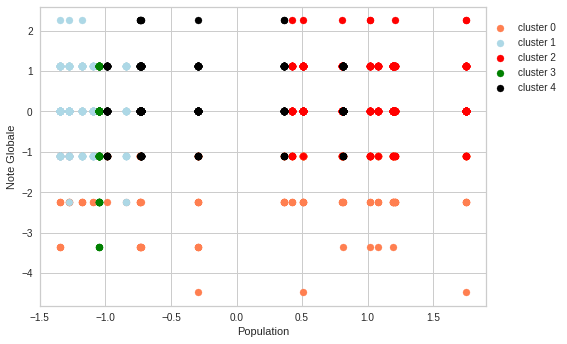

In [196]:
# 3 : croisement de variables géographiques et internes

X1=Z_clust[Z_clust["label5"]==0]["PTOT"]
X2=Z_clust[Z_clust["label5"]==1]["PTOT"]
X3=Z_clust[Z_clust["label5"]==2]["PTOT"]
X4=Z_clust[Z_clust["label5"]==3]["PTOT"]
X5=Z_clust[Z_clust["label5"]==4]["PTOT"]


Y1=Z_clust[Z_clust["label5"]==0]["Note Globale"]
Y2=Z_clust[Z_clust["label5"]==1]["Note Globale"]
Y3=Z_clust[Z_clust["label5"]==2]["Note Globale"]
Y4=Z_clust[Z_clust["label5"]==3]["Note Globale"]
Y5=Z_clust[Z_clust["label5"]==4]["Note Globale"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('Population')
plt.ylabel('Note Globale')
plt.legend(loc=(1,0.7))
plt.show()

On retrouve les caractéristiques données plus haut :
 - cluster 0 : notes faibles
 - cluster 2 : notes élevées dans des arrondissements peuplés

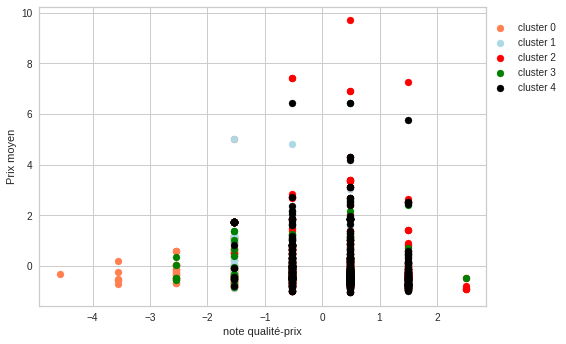

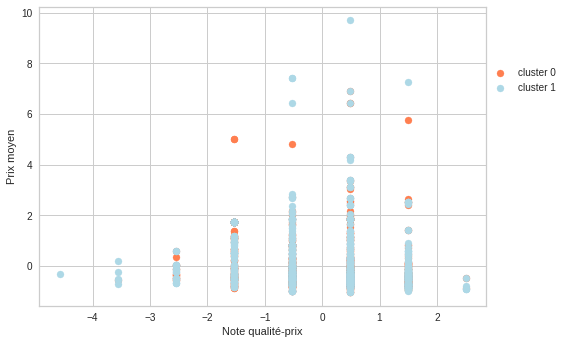

In [198]:
# pour le prix moyen avec 5 clusters 

X1=Z_clust[Z_clust["label5"]==0]["Note qualité-prix"]
X2=Z_clust[Z_clust["label5"]==1]["Note qualité-prix"]
X3=Z_clust[Z_clust["label5"]==2]["Note qualité-prix"]
X4=Z_clust[Z_clust["label5"]==3]["Note qualité-prix"]
X5=Z_clust[Z_clust["label5"]==4]["Note qualité-prix"]


Y1=Z_clust[Z_clust["label5"]==0]["Prix moyen"]
Y2=Z_clust[Z_clust["label5"]==1]["Prix moyen"]
Y3=Z_clust[Z_clust["label5"]==2]["Prix moyen"]
Y4=Z_clust[Z_clust["label5"]==3]["Prix moyen"]
Y5=Z_clust[Z_clust["label5"]==4]["Prix moyen"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('note qualité-prix')
plt.ylabel('Prix moyen')
plt.legend(loc=(1,0.7))
plt.show()

# pour le prix moyen avec 2 clusters

X1=Z_clust[Z_clust["label2"]==0]["Note qualité-prix"]
X2=Z_clust[Z_clust["label2"]==1]["Note qualité-prix"]
Y1=Z_clust[Z_clust["label2"]==0]["Prix moyen"]
Y2=Z_clust[Z_clust["label2"]==1]["Prix moyen"]

plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')

plt.xlabel('Note qualité-prix')
plt.ylabel('Prix moyen')
plt.legend(loc=(1,0.7))
plt.show()

Le facteur prix-moyen est plus dur à exploiter. Dans le cas de 5 clusters, on voit conformément à ce qui a été dit plus haut que le cluster 0 pratique des prix plus faibles, à la différence du cluster 2.

Enfin, ces 5 groupes coincident-ils avec les résultats de l'ACP précédente ?

In [205]:
# on récupère les coordonnées sur le premier plan factoriel qu'on avait obtenus dans notre ACP, dans la variable coord

print(coord)

[[-2.03171702 -0.23083157 -1.99423921 ... -0.34795277  0.21601587
  -0.02116933]
 [-0.32483901  0.0043953  -0.33629582 ... -0.0933585  -0.19083529
   0.11465356]
 [-1.0205849   3.10940652 -0.67149866 ...  0.10017136 -0.1899735
  -0.05834839]
 ...
 [ 2.14569066 -1.45015299 -2.75955362 ...  0.3443107   0.07512585
   0.04096318]
 [-3.36284614 -1.80645461 -1.82006929 ... -0.371347    0.27286808
  -0.02880292]
 [ 1.29400026 -2.3732674  -2.76526281 ...  0.46282195  0.06443017
   0.04025896]]


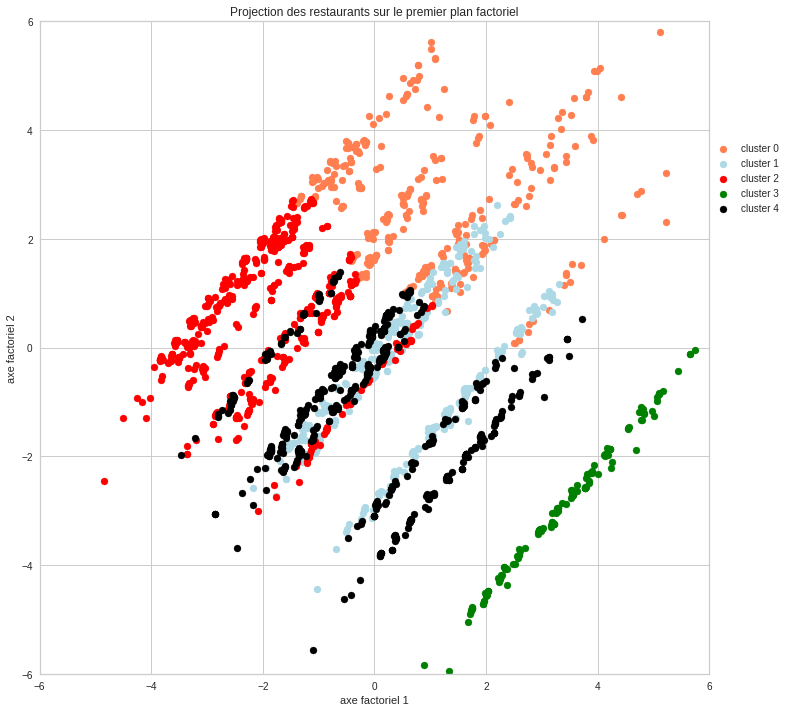

In [218]:
# on veut les deux premières colonnes, qu'on ajoute à notre dataframe Z_clust

Z_clust["coordonnees1"]=coord[:,0]
Z_clust["coordonnees2"]=coord[:,1]

# graphique 

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) 
axes.set_ylim(-6,6) 

X1=Z_clust[Z_clust["label5"]==0]["coordonnees1"]
X2=Z_clust[Z_clust["label5"]==1]["coordonnees1"]
X3=Z_clust[Z_clust["label5"]==2]["coordonnees1"]
X4=Z_clust[Z_clust["label5"]==3]["coordonnees1"]
X5=Z_clust[Z_clust["label5"]==4]["coordonnees1"]


Y1=Z_clust[Z_clust["label5"]==0]["coordonnees2"]
Y2=Z_clust[Z_clust["label5"]==1]["coordonnees2"]
Y3=Z_clust[Z_clust["label5"]==2]["coordonnees2"]
Y4=Z_clust[Z_clust["label5"]==3]["coordonnees2"]
Y5=Z_clust[Z_clust["label5"]==4]["coordonnees2"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('axe factoriel 1')
plt.ylabel('axe factoriel 2')
plt.title("Projection des restaurants sur le premier plan factoriel")
plt.legend(loc=(1,0.7))
plt.show()

On voit que seul le groupe 3 a pu être identifié, celui qui caractérise les restaurants situés dans les arrondissements très aisés. Pour le reste, c'est moins net. Globalement quand même, les clusters forment des "axes" dans le plan factoriel. L'une des limites empêchant la localisation de tous les groupes, au delà de la méthode du k-means, est que le permier plan factoriel ne contient que 40% de l'inertie total (les deux premières valeurs propres expliquent environ 40% de la variance totale). Ce plan présente donc des lacunes certaines en terme de représentativité de l'information globale, mais il a quand même pu discriminer les restaurants situés dans les arrondissements très aisés.

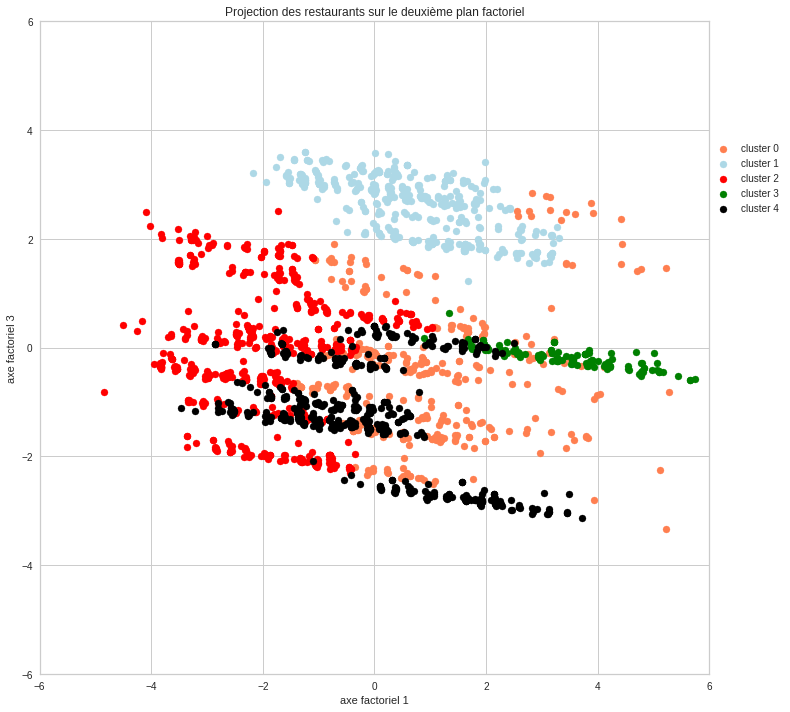

In [219]:
# pour le 2ème plan factoriel

Z_clust["coordonnees3"]=coord[:,2]

# graphique 

fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6) 
axes.set_ylim(-6,6) 

X1=Z_clust[Z_clust["label5"]==0]["coordonnees1"]
X2=Z_clust[Z_clust["label5"]==1]["coordonnees1"]
X3=Z_clust[Z_clust["label5"]==2]["coordonnees1"]
X4=Z_clust[Z_clust["label5"]==3]["coordonnees1"]
X5=Z_clust[Z_clust["label5"]==4]["coordonnees1"]


Y1=Z_clust[Z_clust["label5"]==0]["coordonnees3"]
Y2=Z_clust[Z_clust["label5"]==1]["coordonnees3"]
Y3=Z_clust[Z_clust["label5"]==2]["coordonnees3"]
Y4=Z_clust[Z_clust["label5"]==3]["coordonnees3"]
Y5=Z_clust[Z_clust["label5"]==4]["coordonnees3"]


plt.scatter(X1, Y1, c='coral',label='cluster 0')
plt.scatter(X2, Y2, c='lightblue',label='cluster 1')
plt.scatter(X3, Y3, c='red',label='cluster 2')
plt.scatter(X4, Y4, c='green',label='cluster 3')
plt.scatter(X5, Y5, c='black',label='cluster 4')


plt.xlabel('axe factoriel 1')
plt.ylabel('axe factoriel 3')
plt.title("Projection des restaurants sur le deuxième plan factoriel")
plt.legend(loc=(1,0.7))
plt.show()

Ce plan représente en gros 35% de l'inertie totale. Il semble un peu discriminer le cluster 1, celui caractérisé par les restaurants dans des arrondissements peu peuplés.

On a vu que la variable Prix moyen se prêtait très mal à des régressions linéaires, et au vu de l'aspect de nos graphiques, des régressions types polynomiales n'arrangeraient pas grand-chose. Par ailleurs, nous avons standardiser les données mais cela n'a pas été plus concluant. En outre, cette variable souffre de beaucoup de non-réponses. 
Scipy offre la possibilité de traiter ces non-réponses, en remplaçant par exemple les valeurs manquantes de la variable par leur moyenne sur les données observées, ou encore par l'occurence la plus fréquente de la variable en question. 
Malheureusement, cela n'arrangera pas le fondement du problème qui est que le prix moyen semble peu corrélé à nos variables explicatives voire pas du tout ! La plus grande corrélation, en reprenant notre matrice des corrélations de départ, a été de 0.3, obtenu pour le nombre d'avis : plus le nombre d'avis est important pour un restaurant et plus son prix est élevé. Mais cela n'a jamais pu se traduire dans un modèle de régression. 

En guise de piste d'amélioration, une des solutions serait peut-être d'envisager des relations non linéaires mais simplement monotones. La matrice de corrélation avec la méthode des rangs de Spearman a permis d'avoir une corrélation entre nombre d'avis et prix moyen qui monte à 0.5 : cela est mieux mais est-ce réellement suffisant ? 

Dans notre clustering, cerains groupes de restaurants ont pu être identifiés, mais ils ont pu surtout être discriminés sur des critères plus géographiques qu'internes au restaurant, même si le clustering avec 5 clusters a amélioré cela.
En outre, deux des groupes de notre clustering a un peu près pu être identifié sur les deux plans factoriels de notre ACP. Une des solutions serait non pas de faire une ACP normée mais une ACP sur les rangs, pour se débarasser des "outliers", et qui peut-être fonctionnerait mieux pour identifier nos clusters ; notamment comme dit plus haut la corrélation du prix moyen avec les autres variables, notamment le nombre d'avis, augmente en considérant les rangs de Spearman, ce qui pourrait peut-être aider à discriminer cerains clusters en fonction du prix_moyen , chose qu'on n'a pas pu faire ici.

### Un petit plus : quelle note (cuisine/qualité-prix /service /ambiance) contribue le plus à la note globale d'un restaurant ?

Lorsque des personnes notent un restaurant sur TripAdvisor, souvent elles ne remplissent que le premier champ, Note de Cuisine, si bien que celle-ci constitue la note globale du restaurant. Mais que se passe-t-il si les personnes remplissent les quatre critères ? Y en a-t-il un dont on peut dire que, lorsqu'il est rempli, influence davantage la note finale du restaurant (de par sa distribution étalée par exemple)

In [247]:
# on fait d'aord une régression linéaire de Note Globale sur les 4 autres variables de note. 
# Pour enlever le problème de mulitcolinéarité (car à partir de toutes les notes on peut reconstituer la note globale), on 
# enlève la note de service (arbitraire).


# dkbis était notre dataframe de 2000 observations environ, qui ne contient aucun doublon et aucune valeur manquante

X = dkbis[["Note ambiance", "Note qualité-prix", "Note de cuisine"]]     
X = sm.add_constant(X) 
y = dkbis["Note Globale"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Note Globale   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     2789.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:13:46   Log-Likelihood:                 408.88
No. Observations:                2090   AIC:                            -809.8
Df Residuals:                    2086   BIC:                            -787.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1702      0.04

Le R² de la régression est 0.8. Nos trois variables sont statistiquement significatives (p-valeurs associées sont nulles). Le coefficient devant la variable de cuisine est le plus grand, 0.63. Ainsi on prédit qu'une augmentation de 1 étoile dans la notation du critère de cuisine augmente sa note globale de 0.63 étoiles (alors que si les 4 notes contribuaient dans une parfaite proportionnalité, ce serait 0.25 étoiles en plus). La note d'ambiance semble moins déterminante.

#### En utilisant Scikit-learn : 

In [267]:
#base d'apprentissage et base de test

from sklearn.model_selection import train_test_split
 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1672, 4)
(418, 4)
(1672,)
(418,)


On va donc entrainer notre modèle sur 1672 données, et le tester sur les 418 restantes



In [268]:
#entrainement du modèle

lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

On va utiliser deux indicateurs de performance, l'un utilisé en Machine Learning et l'autre plus en économétrie : 

- le "Mean squared error" (MSE), afin d'évaluer la qualité de la prédiction. 
- le "R²" afin d'évaluer la qualité de la régresseion linéaire



In [269]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Evaluation du training set

y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.19888010959172
le score R2 est 0.7959403513983255


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.19970016034540256
le score R2 est 0.8156267024361437


L'erreur quadratique ne change pas, et on a légèrement augmenté la qualité du modèle de régression. que se passe-t-il si on l'entraine sur plus de données ?

In [270]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.05, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1985, 4)
(105, 4)
(1985,)
(105,)


On va le tester sur 105 données : 

In [271]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.19962321631497018
le score R2 est 0.7993014415877013


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.1865728409815135
le score R2 est 0.8196127330031293


L'erreur quadratique baisse très légèrement, et le R² augmente (on atteint 0.819 contre 0.816 tout à l'heure)

In [272]:
# dernier essai 

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.01, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2069, 4)
(21, 4)
(2069,)
(21,)


On ne teste plus que sur 20 données ! 

In [273]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.19945466473305812
le score R2 est 0.7992115354186391


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.14431016916099038
le score R2 est 0.9058050011162698


C'est beaucoup mieux ! On réduit l'erreur quadratique, qui passe de 0.199 à 0.144, et on améliore le R² qui atteint 0.91

On peut se demander si il ne faut pas utiliser quasi-entièrement nos données pour entrainer notre algo.

Vérifions : 

In [283]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 3, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2087, 4)
(3, 4)
(2087,)
(3,)


On va tester sur 3 données 

In [284]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)


y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))
print('\n')
 
# Evaluation du testing set
y_test_predict = lmodellineaire.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)
 
print('La performance du modèle sur la base de test')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.19895446261179972
le score R2 est 0.8006730437655999


La performance du modèle sur la base de test
--------------------------------------
Lerreur quadratique moyenne est 0.21328577145519761
le score R2 est 0.18116523450570188


Les performances s'effondrent, ce qui est normal. Il y a bien trop peu de données à tester, et il suffit que l'une d'entre elle ait une valeur un peu particulière pour faire échouer l'algo.

De manière générale, il y a un arbitrage à faire entre entrainement et test (souvent on alloue 20% de l'échantillon à la partie test, c'est ce qu'on a fait nous au départ).

# Conclusion : difficultés et ouverture

Partie scrapping : la table des restaurants que nous avons utilisée de base était très dense mais beaucoup d'informations manquaient. Nous avons été ainsi amenés à utiliser entre-autre Selenium pour pouvoir récolter des données de capital social, de prix ou d'avis. 

#### Difficultés : 

 - faire tourner nos scrappings sur plusieurs milliers de restaurants a été long, c'est d'ailleurs pour cette raison que nous en sommes restés aux restaurants parisiens.
 
 
 - nous avons pu nous confronter à la sécurité mise par les sites contre le scrapping. Entre-autre, si pour le scrapping sur societe.com, il n'y a pas eu de problèmes à ce niveau-là, pour les PagesJaunes, nous n'avons tout simplement pas pu poursuivre notre scrapping après 500 itérations sur leur site, une demande de confirmation anti-robot étant demandée(via des vignettes sur lesquelles cliquer dessus). Pour Trip Advisor, nous étions bloqués temporairement toutes les 500 itérations, mais pouvions réexécuter l'algorithme après quelques minutes : la sécurité contre les robots était clairement moins développée que pour le site des pages jaunes
 
#### Solutions : 

- pour la rapidité : nous avons utilisé plusieurs Webdrivers à la fois sur des navigateurs différents. Nous avons même testé un Webdriver distant. En outre, une des directions à prendre est l'utilisation de Selenium Grid, qui permet d'éxécuter beaucoup de tests en parallèle, via la connection de plusieurs nodes à un hub. Nous avons un peu expérimenté cette solution, mais qui reste encore assez complexe pour nous


- pour la sécurité : il existe des librairies comme Fake-User-agent, qui permettent de simuler avec un degré plus ou moins élevé ce que notre ordinateur envoie au site lorsqu'il s'agit d'un utilisateur réel. Nous avons un peu expériementé cette solution, en essayant par exemple de jouer sur les headers de la requête, avec un User-Agent répandu et pouvant appartenir à un vrai utilisateur. Ces tentatives n'ont pas marché sur le site des pages jaunes... et nous ne l'avons pas essayer sur Tripadvisor (cela aurait sans doute plus marcher, le site semblant beaucoup moins sécurisé contre le scrapping). On peut aller plus loin, en se servant de proxys gratuits par exemple, en jouant sur des adresses IP tournantes... mais on tombe dans un tout autre domaine...

#### Perspectives :

- essayer de faire tourner nos algo de scrapping à l'échelle des restaurants français 
- scrapper leur localisation via le site open source openstreetmap


Partie statistiques descriptives et modélisation : nous avons pu dégager un certain nombre d'éléments de statistique descriptive. Concernant la modélisation, il semble que notre variable de prix moyen ne puisse pas s'expliquer linéairement par d'autres variables explicatives. Des relations plus complexes sont peut-être à chercher, polynomiales ou autre, tout en traitant correctement la non réponse élevée de cette variable. Les clusterings ont montré que ce sont surtout les facteurs géographiques qui discriminent un restaurant : il est clairement plus facile d'isloer les restaurants situés dans un arrondissement aisé que ceux ayant récolté un grand nombre d'avis par exemple. En outre, il est nécessaire d'affiner pour pouvoir avoir des critères internes au restaurant qui soient discriminants, aptes à séparer plusieurs groupes.